In [263]:
!pip install pmdarima

In [5]:
from db_lib.lib_DI_dbcontrols import SQLTools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.plotting import lag_plot
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [6]:
# append to SQL
def append_df(schema, table, df):
    engine = SQLTools(schema, table, df)
    engine.append()

# extract from SQL
def read_df(schema, table):
    engine = SQLTools(schema, table)
    df = engine.fetch()
    return df
#df_1 = read_df('research','populartimes')

# extract from SQL using query
def read_query(query):
    engine = SQLTools(sql_query=query)
    df = engine.query()
    return df

In [7]:
df_raw = read_query("SELECT b.TradeDate, b.Market, b.StockCode, b.StockName, b.BuyQty, b.SellQty, b.TotalQty, b.BuyConsideration, b.SellConsideration, b.TotalConsideration, b.CountryCode, c.BBGCode, c.Region, a.InfoCode, a.Open_, a.High, a.Low, a.Close_, a.VWAP, a.Volume, a.Currency from [research].[BOCI_Retail] b join [research].[BOCI_SecMstr] c on b.StockCode = c.stockcode and b.CountryCode = c.countrycode join [research].[BOCI_px] a on a.InfoCode = c.InfoCode and b.TradeDate = a.MarketDate order by [TradeDate];")
df_raw.reset_index(inplace=True, drop=True)

_cnxn_engine:	Building Connection to Database...
query:	SELECT b.TradeDate, b.Market, b.StockCode, b.StockName, b.BuyQty, b.SellQty, b.TotalQty, b.BuyConsideration, b.SellConsideration, b.TotalConsideration, b.CountryCode, c.BBGCode, c.Region, a.InfoCode, a.Open_, a.High, a.Low, a.Close_, a.VWAP, a.Volume, a.Currency from [research].[BOCI_Retail] b join [research].[BOCI_SecMstr] c on b.StockCode = c.stockcode and b.CountryCode = c.countrycode join [research].[BOCI_px] a on a.InfoCode = c.InfoCode and b.TradeDate = a.MarketDate order by [TradeDate];


In [8]:
df_raw

,TradeDate,Market,StockCode,StockName,BuyQty,SellQty,TotalQty,BuyConsideration,SellConsideration,TotalConsideration,...,BBGCode,Region,InfoCode,Open_,High,Low,Close_,VWAP,Volume,Currency
0,2015-01-02,010 - HONG KONG MARKET,5,HSBC HOLDINGS PLC,886800.0,152984.0,1039784.0,65428280.00,11279714.85,7.670799e+07,...,5 HK EQUITY,HK,46796,73.600007,74.100007,73.500000,74.000000,73.760499,8.614012e+06,HKD
1,2015-01-02,010 - HONG KONG MARKET,639,SHOUGANG FUSHAN RESOURCES GROUP LTD.,64000.0,112000.0,176000.0,107520.00,187960.00,2.954800e+05,...,639 HK EQUITY,HK,35963,1.448319,1.474337,1.439647,1.448319,1.455258,5.147263e+06,HKD
2,2015-01-02,010 - HONG KONG MARKET,3898,"ZHUZHOU CRRC TIMES ELECTRIC CO., LTD. - H SHARES",317500.0,563500.0,881000.0,16012700.00,28388800.00,4.440150e+07,...,3898 HK EQUITY,HK,33466,45.600007,54.350007,45.600007,52.199997,50.467698,1.194964e+07,HKD
3,2015-01-02,010 - HONG KONG MARKET,1359,"CHINA CINDA ASSET MANAGEMENT CO., LTD. - H SHARES",5289000.0,6501449.0,11790449.0,20670579.80,25593498.55,4.626408e+07,...,1359 HK EQUITY,HK,270042,3.790000,4.030000,3.780000,3.990000,3.938600,9.133819e+07,HKD
4,2015-01-02,010 - HONG KONG MARKET,1109,CHINA RESOURCES LAND LTD.,904000.0,3756254.0,4660254.0,19390000.00,81272212.80,1.006622e+08,...,1109 HK EQUITY,HK,44169,20.121302,21.427242,20.121302,21.185400,20.935734,2.784911e+07,HKD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195101,2020-09-24,233 - SHENZHEN-HONG KONG STOCK CONNECT,2429,"SHENZHEN MTC CO., LTD.",90000.0,0.0,90000.0,554900.00,0.00,5.549000e+05,...,002429 CH EQUITY,CN,234393,6.350000,6.380000,6.130000,6.150000,6.229300,4.441286e+07,CNY
2195102,2020-09-24,233 - SHENZHEN-HONG KONG STOCK CONNECT,2507,CHONGQING FULING ZHACAI GROUP,800.0,0.0,800.0,36120.00,0.00,3.612000e+04,...,002507 CH EQUITY,CN,243699,44.800004,45.190003,43.809998,43.820008,44.450699,6.088902e+06,CNY
2195103,2020-09-24,233 - SHENZHEN-HONG KONG STOCK CONNECT,2030,"DA AN GENE CO., LTD. OF SUN YAT-SEN UNIVERSITY",1000.0,0.0,1000.0,35990.00,0.00,3.599000e+04,...,002030 CH EQUITY,CN,19559,36.259995,36.979996,35.610001,36.479996,36.321503,5.235210e+07,CNY
2195104,2020-09-24,233 - SHENZHEN-HONG KONG STOCK CONNECT,2506,GCL SYSTEM INTEGRATION TECHNOLOGY,3500.0,0.0,3500.0,14280.00,0.00,1.428000e+04,...,002506 CH EQUITY,CN,243514,3.980000,4.160000,3.940000,4.020001,4.051601,5.553629e+08,CNY


In [9]:
df_raw['StockName'].value_counts().head(50)

ALIBABA GROUP HOLDING LTD                                     1443
JD.COM INC                                                    1441
TESLA MOTORS INC                                              1427
BAIDU INC                                                     1426
FACEBOOK INC                                                  1421
APPLE INC                                                     1419
CHINA POWER INTERNATIONAL DEVELOPMENT LTD.                    1413
TECHTRONIC INDUSTRIES CO. LTD.                                1413
CHINA CONSTRUCTION BANK CORPORATION - H SHARES                1413
NINE DRAGONS PAPER (HOLDINGS) LTD.                            1413
CHINA MENGNIU DAIRY CO. LTD.                                  1413
CHINA STATE CONSTRUCTION INTERNATIONAL HOLDINGS LTD.          1413
CHINA COMMUNICATIONS SERVICES CORPORATION LTD. - H SHARES     1413
ALUMINUM CORPORATION OF CHINA LTD. - H SHARES                 1413
ZHUZHOU CRRC TIMES ELECTRIC CO., LTD. - H SHARES              

In [10]:
df_raw['NetConsideration'] = df_raw['BuyConsideration'] - df_raw['SellConsideration']

In [11]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2195106 entries, 0 to 2195105
Data columns (total 22 columns):
 #   Column              Dtype         
---  ------              -----         
 0   TradeDate           datetime64[ns]
 1   Market              object        
 2   StockCode           object        
 3   StockName           object        
 4   BuyQty              float64       
 5   SellQty             float64       
 6   TotalQty            float64       
 7   BuyConsideration    float64       
 8   SellConsideration   float64       
 9   TotalConsideration  float64       
 10  CountryCode         object        
 11  BBGCode             object        
 12  Region              object        
 13  InfoCode            int64         
 14  Open_               float64       
 15  High                float64       
 16  Low                 float64       
 17  Close_              float64       
 18  VWAP                float64       
 19  Volume              float64       
 20  Cu

In [12]:
df_raw.isna().sum()

TradeDate                0
Market                   0
StockCode                0
StockName                0
BuyQty                   0
SellQty                  0
TotalQty                 0
BuyConsideration         0
SellConsideration        0
TotalConsideration       0
CountryCode              0
BBGCode                  0
Region                   0
InfoCode                 0
Open_                 2537
High                  2530
Low                   2527
Close_                 105
VWAP                  2126
Volume                  49
Currency                 0
NetConsideration         0
dtype: int64

Text(0, 0.5, 'Stock Tickers')

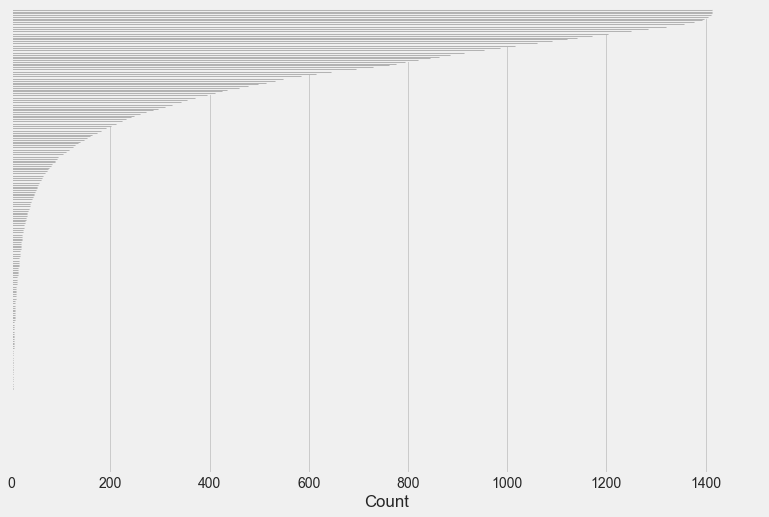

In [13]:
#plt.rcParams['figure.figsize'] = [15, 10]
plt.figure(figsize=(12, 8))
df_raw.StockName.value_counts().sort_values().plot(kind = 'barh', color='black')
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.xlabel('Count')
plt.ylabel('Stock Tickers')

In [14]:
# 'ALIBABA GROUP HOLDING LTD', 'JD.COM INC', 'TESLA MOTORS INC', 'BAIDU INC', 'FACEBOOK INC', 'APPLE INC'
company_list = ['ALIBABA GROUP HOLDING LTD', 'JD.COM INC', 'TESLA MOTORS INC', 'BAIDU INC']
tech_list = ["Stock 1", "Stock 2", "Stock 3", "Stock 4"]

In [15]:
df_raw.set_index('TradeDate', inplace=True)
alibaba = df_raw[df_raw['StockName'] == 'ALIBABA GROUP HOLDING LTD']
jd = df_raw[df_raw['StockName'] == 'JD.COM INC']
tesla = df_raw[df_raw['StockName'] == 'TESLA MOTORS INC']
baidu = df_raw[df_raw['StockName'] == 'BAIDU INC']

top4_list = [alibaba, jd, tesla, baidu]

df = pd.concat(top4_list, axis=0)

#df_top4 = df_raw[df_raw['StockName'].isin(company_list)]

In [16]:
# We'll use pct_change to find the percent change for each day
for company in top4_list:
    company['Daily Return'] = company['VWAP'].pct_change()

C:\Users\junkeat.teo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
from scipy.stats import pearsonr
corr,_ = pearsonr(alibaba['NetConsideration'], alibaba['VWAP'])
corr

0.007242421866139561

<Figure size 1440x1440 with 0 Axes>

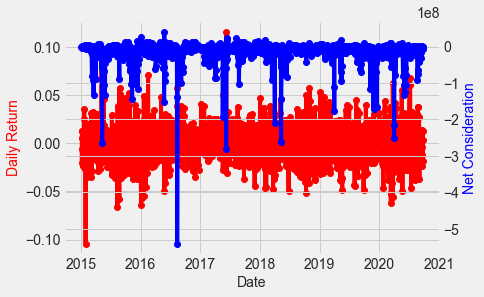

-0.2116861062614685


In [18]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(top=1.25, bottom=1.2)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(alibaba.reset_index().TradeDate, alibaba['Daily Return'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("Daily Return",color="red",fontsize=14)


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(alibaba.reset_index().TradeDate, alibaba["NetConsideration"],color="blue",marker="o")
ax2.set_ylabel("Net Consideration",color="blue",fontsize=14)
plt.show()

corr,_ = pearsonr(alibaba['NetConsideration'][1:], alibaba['Daily Return'].dropna())
print(corr)

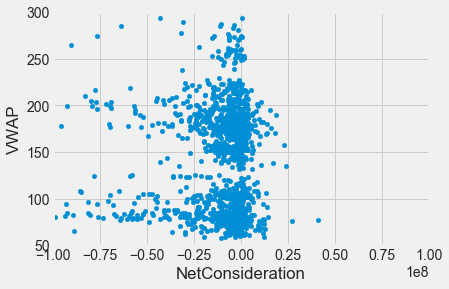

In [19]:
alibaba.plot(x='NetConsideration', y='VWAP', kind='scatter')
plt.ylim(50,300)
plt.xlim(-1e8,1e8)
plt.show()

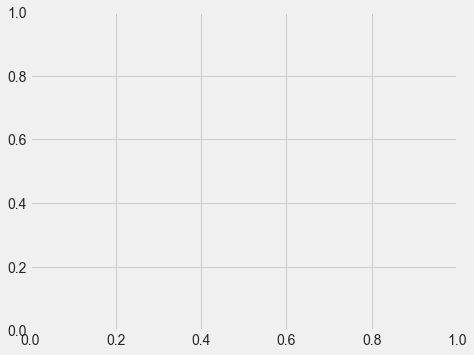

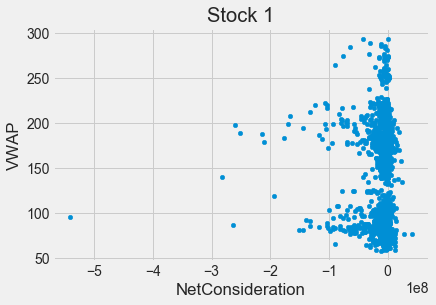

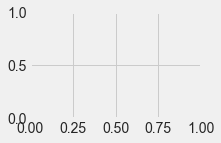

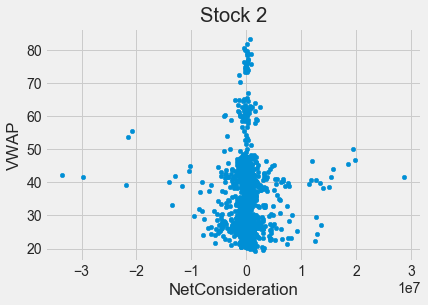

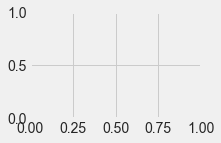

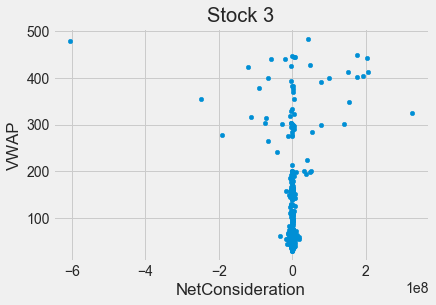

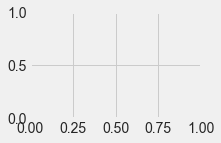

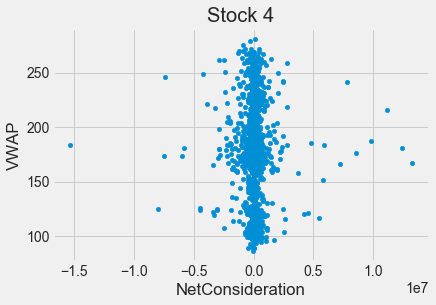

In [20]:
plt.figure(figsize=(15, 12))
#plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(top4_list, 1):
    plt.subplot(2, 2, i)
    company.plot(x='NetConsideration', y='VWAP', kind='scatter')
    plt.ylabel('VWAP')
    plt.xlabel('NetConsideration')
    plt.title(f"{tech_list[i - 1]}")
    plt.show()

<Figure size 1440x1080 with 0 Axes>

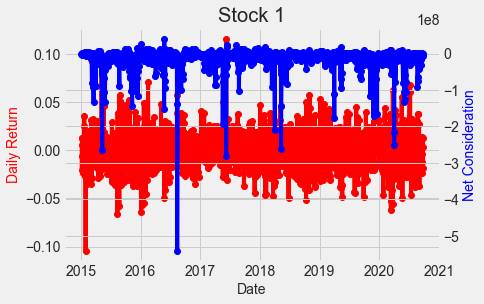

Correlation:  -0.2116861062614685


In [21]:
plt.figure(figsize=(20,15))
plt.subplots_adjust(top=1.25, bottom=1.2)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(alibaba.reset_index().TradeDate, alibaba['Daily Return'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("Daily Return",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(alibaba.reset_index().TradeDate, alibaba["NetConsideration"],color="blue",marker="o")
ax2.set_ylabel("Net Consideration",color="blue",fontsize=14)
plt.title('Stock 1')
plt.show()

corr,_ = pearsonr(alibaba['NetConsideration'][1:], alibaba['Daily Return'].dropna())
print('Correlation: ', corr)

<Figure size 1440x1080 with 0 Axes>

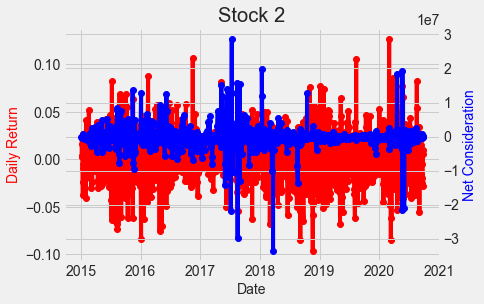

Correlation:  -0.17997419984289603


In [22]:
plt.figure(figsize=(20,15))
plt.subplots_adjust(top=1.25, bottom=1.2)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(jd.reset_index().TradeDate, jd['Daily Return'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("Daily Return",color="red",fontsize=14)


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(jd.reset_index().TradeDate, jd["NetConsideration"],color="blue",marker="o")
ax2.set_ylabel("Net Consideration",color="blue",fontsize=14)
plt.title('Stock 2')
plt.show()

corr,_ = pearsonr(jd['NetConsideration'][1:], jd['Daily Return'].dropna())
print('Correlation: ', corr)

<Figure size 1440x1080 with 0 Axes>

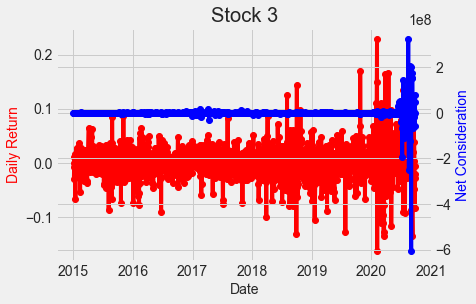

Correlation:  -0.13125052879454618


In [23]:
plt.figure(figsize=(20,15))
plt.subplots_adjust(top=1.25, bottom=1.2)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(tesla.reset_index().TradeDate, tesla['Daily Return'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("Daily Return",color="red",fontsize=14)


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(tesla.reset_index().TradeDate, tesla["NetConsideration"],color="blue",marker="o")
ax2.set_ylabel("Net Consideration",color="blue",fontsize=14)
plt.title('Stock 3')
plt.show()

corr,_ = pearsonr(tesla['NetConsideration'][1:], tesla['Daily Return'].dropna())
print('Correlation: ', corr)

<Figure size 1440x1080 with 0 Axes>

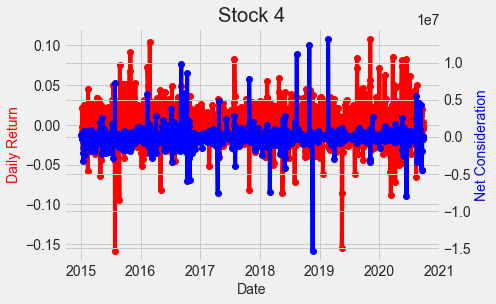

Correlation:  -0.2249751735509905


In [24]:
plt.figure(figsize=(20,15))
plt.subplots_adjust(top=1.25, bottom=1.2)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(baidu.reset_index().TradeDate, baidu['Daily Return'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("Daily Return",color="red",fontsize=14)


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(baidu.reset_index().TradeDate, baidu["NetConsideration"],color="blue",marker="o")
ax2.set_ylabel("Net Consideration",color="blue",fontsize=14)
plt.title('Stock 4')
plt.show()

corr,_ = pearsonr(baidu['NetConsideration'][1:], baidu['Daily Return'].dropna())
print('Correlation: ', corr)

In [25]:
df.isna().sum()

Market                0
StockCode             0
StockName             0
BuyQty                0
SellQty               0
TotalQty              0
BuyConsideration      0
SellConsideration     0
TotalConsideration    0
CountryCode           0
BBGCode               0
Region                0
InfoCode              0
Open_                 0
High                  0
Low                   0
Close_                0
VWAP                  0
Volume                0
Currency              0
NetConsideration      0
dtype: int64

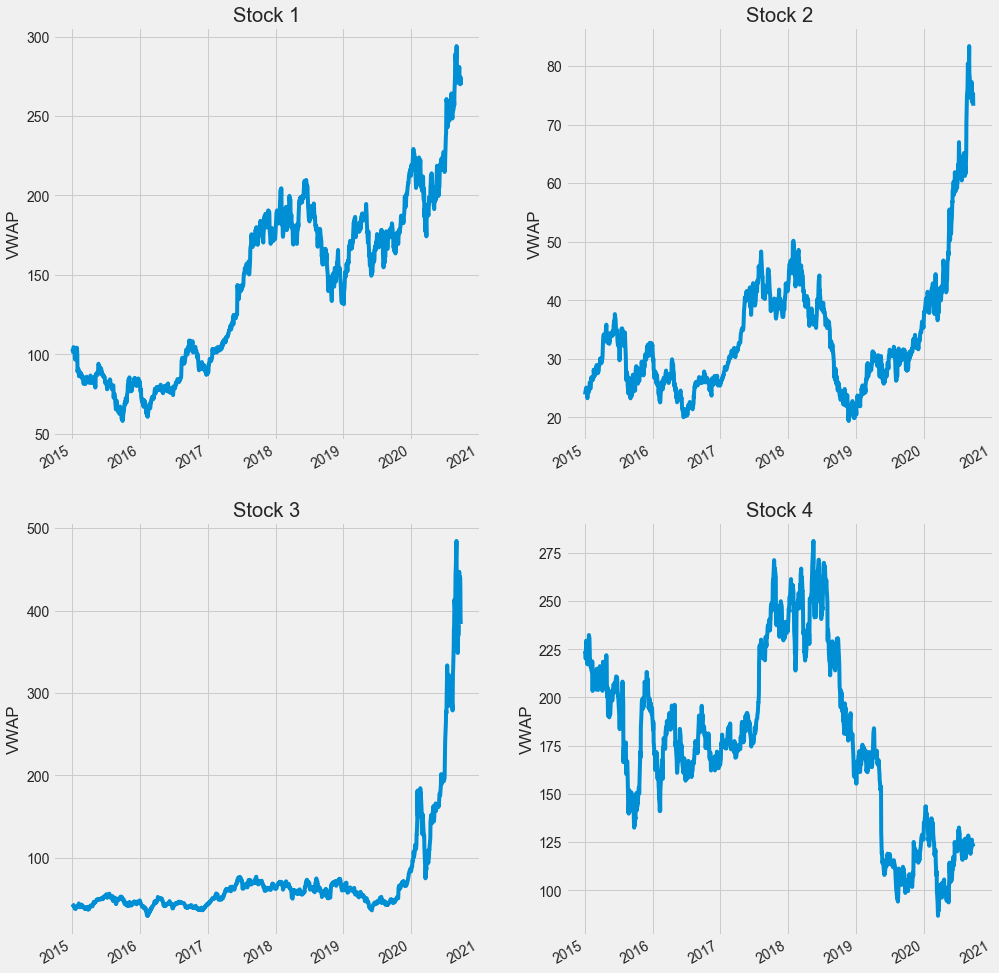

In [26]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(top4_list, 1):
    plt.subplot(2, 2, i)
    company['VWAP'].plot()
    plt.ylabel('VWAP')
    plt.xlabel(None)
    plt.title(f"{tech_list[i - 1]}")

# alibaba = df_top5[df_top5['StockName'] == 'ALIBABA GROUP HOLDING LTD']
# jd = df_top5[df_top5['StockName'] == 'JD.COM INC']
# tesla = df_top5[df_top5['StockName'] == 'TESLA MOTORS INC']

# # fig, axs = plt.subplots(2)
# # fig.suptitle('VWAP')
# # axs[0].plot(alibaba['TradeDate'], alibaba['VWAP'], legend=False)
# # axs[0].plot(alibaba['TradeDate'], alibaba['VWAP'])
# df_top3


In [150]:
box_df1


,VWAP,Volume,VWAP,Volume,VWAP,Volume,VWAP,Volume
TradeDate,,,,,,,,
2015-01-02,103.38381,12303387.0,23.899308,3358492.0,43.435722,23822210.0,224.03310,3490041.0
2015-01-05,101.30961,18337016.0,24.466599,5033852.0,42.138120,26842385.0,221.99271,2750293.0
2015-01-06,101.83741,15720407.0,24.542008,9797774.0,41.847282,31309690.0,220.03330,3231378.0
2015-01-07,103.11051,11052157.0,24.932496,9084399.0,42.324962,14841950.0,224.71711,2280656.0
2015-01-08,104.44220,12942055.0,24.989502,12821700.0,42.327742,17212545.0,229.40261,2642130.0
...,...,...,...,...,...,...,...,...
2020-09-18,273.22315,11753469.0,74.526093,9575016.0,441.772470,86406813.0,124.01000,3237714.0
2020-09-21,269.97584,9076430.0,74.176804,9180848.0,439.711430,109476820.0,123.25640,2661011.0
2020-09-22,273.44996,9673301.0,74.885697,7226602.0,427.236090,79580813.0,123.67450,1888007.0


C:\Users\junkeat.teo\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\junkeat.teo\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


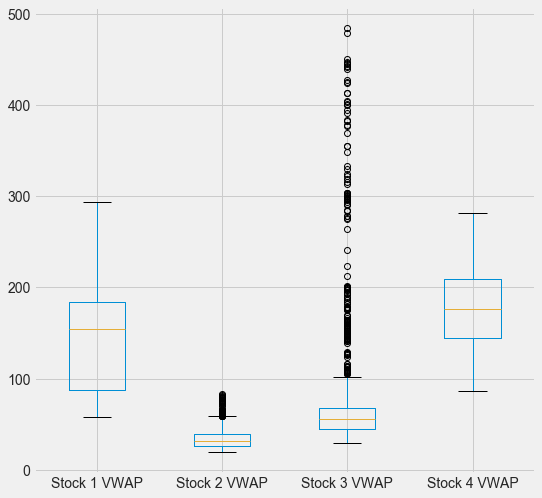

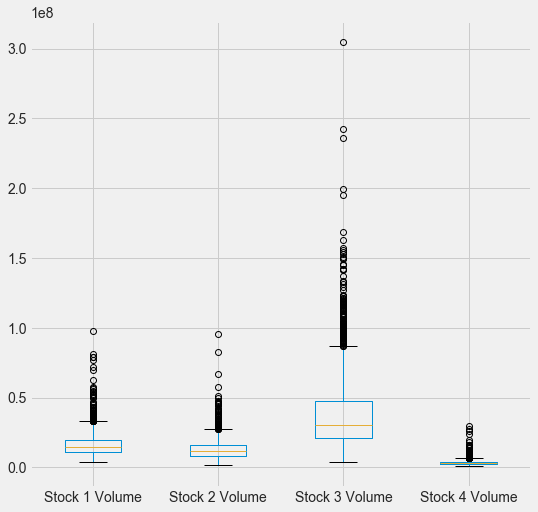

In [154]:
box_df_1 = pd.concat([alibaba['VWAP'], jd['VWAP'], tesla['VWAP'], baidu['VWAP']], axis = 1)
box_df_1.columns = ['Stock 1 VWAP', 'Stock 2 VWAP', 'Stock 3 VWAP', 'Stock 4 VWAP']
box_df_1.plot(kind='box', figsize = (8,8));

box_df_2 = pd.concat([alibaba['Volume'], jd['Volume'], tesla['Volume'], baidu['Volume']], axis = 1)
box_df_2.columns = ['Stock 1 Volume', 'Stock 2 Volume', 'Stock 3 Volume', 'Stock 4 Volume']
box_df_2.plot(kind='box', figsize = (8,8));

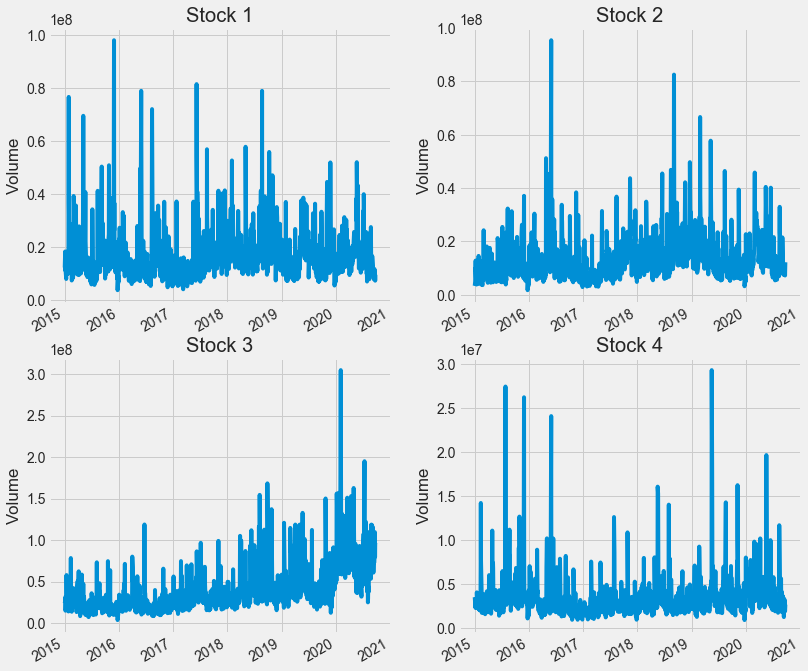

In [153]:
plt.figure(figsize=(12, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(top4_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"{tech_list[i - 1]}")

In [29]:
# moving average
ma_day = [30, 90, 180]

for ma in ma_day:
    for company in top4_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['VWAP'].rolling(ma).mean()

C:\Users\junkeat.teo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


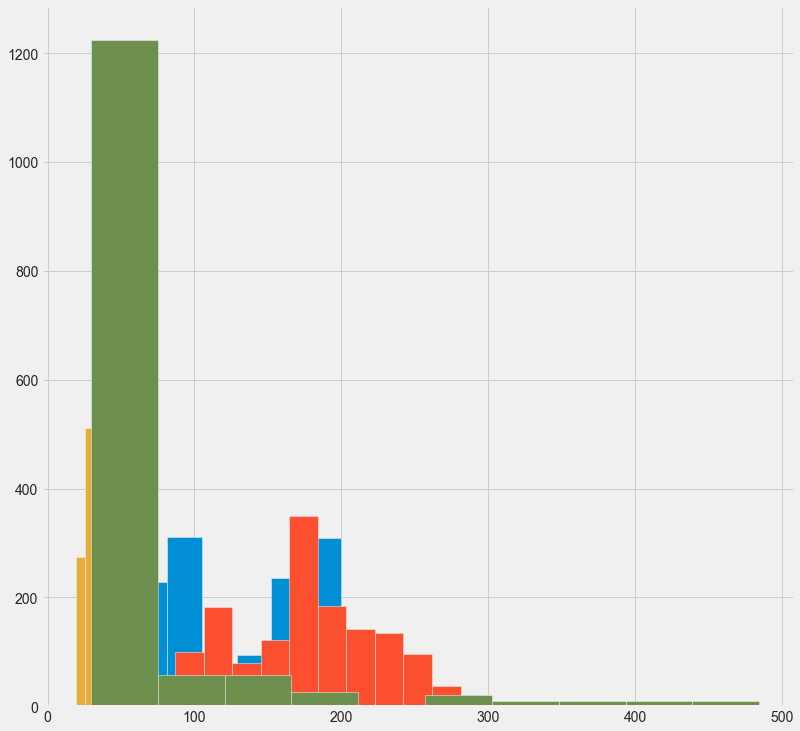

In [32]:
df.groupby("StockName")['VWAP'].hist(figsize=(12, 12));

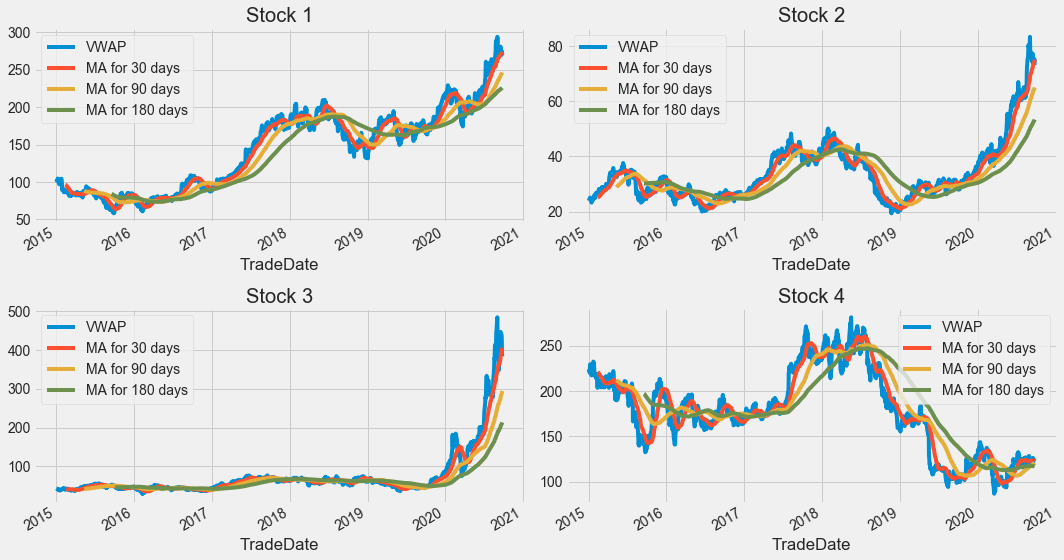

In [97]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

alibaba[['VWAP', 'MA for 30 days', 'MA for 90 days', 'MA for 180 days']].plot(ax=axes[0,0])
axes[0,0].set_title('Stock 1')

jd[['VWAP', 'MA for 30 days', 'MA for 90 days', 'MA for 180 days']].plot(ax=axes[0,1])
axes[0,1].set_title('Stock 2')

tesla[['VWAP', 'MA for 30 days', 'MA for 90 days', 'MA for 180 days']].plot(ax=axes[1,0])
axes[1,0].set_title('Stock 3')

baidu[['VWAP', 'MA for 30 days', 'MA for 90 days', 'MA for 180 days']].plot(ax=axes[1,1])
axes[1,1].set_title('Stock 4')

fig.tight_layout()

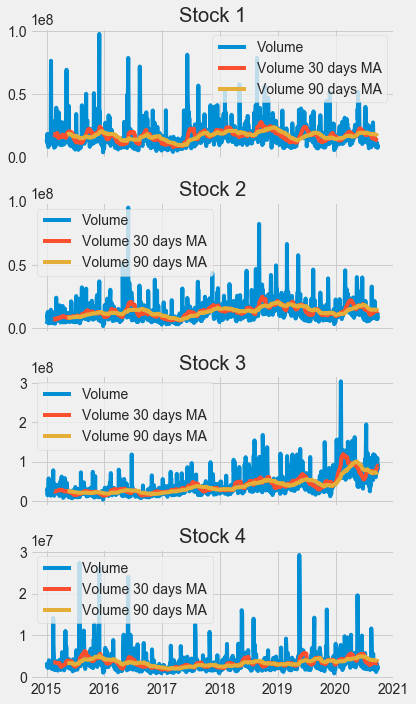

In [115]:
# Volume moving average
ma_day = [30, 90]

for ma in ma_day:
    for company in top4_list:
        column_name = f"Volume MA for {ma} days"
        company[column_name] = company['Volume'].rolling(ma).mean()

        
fig, axes = plt.subplots(4, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(6)

axes[0].plot(alibaba[['Volume']], label='Volume')
axes[0].plot(alibaba[['Volume MA for 30 days']], label='Volume 30 days MA')
axes[0].plot(alibaba[['Volume MA for 90 days']], label='Volume 90 days MA')
axes[0].set_title('Stock 1')
axes[0].legend()

axes[1].plot(jd[['Volume']], label='Volume')
axes[1].plot(jd[['Volume MA for 30 days']], label='Volume 30 days MA')
axes[1].plot(jd[['Volume MA for 90 days']], label='Volume 90 days MA')
axes[1].set_title('Stock 2')
axes[1].legend()

axes[2].plot(tesla[['Volume']], label='Volume')
axes[2].plot(tesla[['Volume MA for 30 days']], label='Volume 30 days MA')
axes[2].plot(tesla[['Volume MA for 90 days']], label='Volume 90 days MA')
axes[2].set_title('Stock 3')
axes[2].legend()

axes[3].plot(baidu[['Volume']], label='Volume')
axes[3].plot(baidu[['Volume MA for 30 days']], label='Volume 30 days MA')
axes[3].plot(baidu[['Volume MA for 90 days']], label='Volume 90 days MA')
axes[3].set_title('Stock 4')
axes[3].legend()

fig.tight_layout()
plt.show()

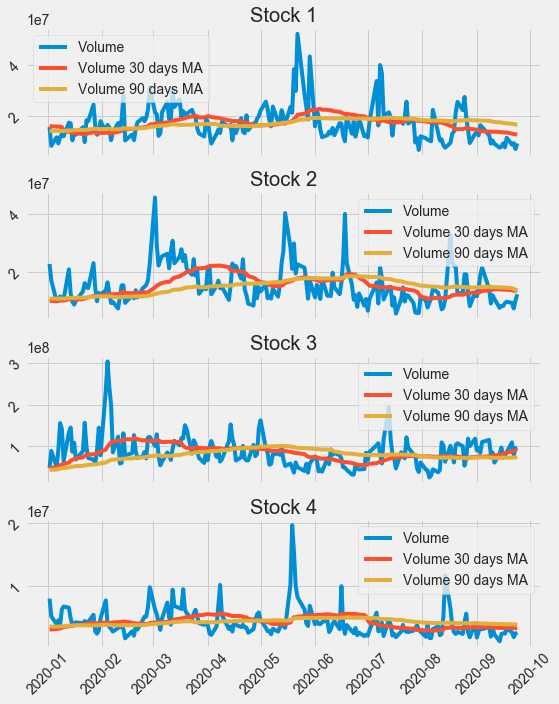

In [134]:
fig, axes = plt.subplots(4, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(8)

axes[0].plot(alibaba.Volume[alibaba.index>'2019-12-31'], label='Volume')
axes[0].plot(alibaba['Volume MA for 30 days'][alibaba.index>'2019-12-31'], label='Volume 30 days MA')
axes[0].plot(alibaba['Volume MA for 90 days'][alibaba.index>'2019-12-31'], label='Volume 90 days MA')
axes[0].set_title('Stock 1')
axes[0].legend()
axes[0].tick_params(labelrotation=45)

axes[1].plot(jd.Volume[jd.index>'2019-12-31'], label='Volume')
axes[1].plot(jd['Volume MA for 30 days'][jd.index>'2019-12-31'], label='Volume 30 days MA')
axes[1].plot(jd['Volume MA for 90 days'][jd.index>'2019-12-31'], label='Volume 90 days MA')
axes[1].set_title('Stock 2')
axes[1].legend()
axes[1].tick_params(labelrotation=45)

axes[2].plot(tesla.Volume[tesla.index>'2019-12-31'], label='Volume')
axes[2].plot(tesla['Volume MA for 30 days'][tesla.index>'2019-12-31'], label='Volume 30 days MA')
axes[2].plot(tesla['Volume MA for 90 days'][tesla.index>'2019-12-31'], label='Volume 90 days MA')
axes[2].set_title('Stock 3')
axes[2].legend()
axes[2].tick_params(labelrotation=45)

axes[3].plot(baidu.Volume[baidu.index>'2019-12-31'], label='Volume')
axes[3].plot(baidu['Volume MA for 30 days'][baidu.index>'2019-12-31'], label='Volume 30 days MA')
axes[3].plot(baidu['Volume MA for 90 days'][baidu.index>'2019-12-31'], label='Volume 90 days MA')
axes[3].set_title('Stock 4')
axes[3].legend()
axes[3].tick_params(labelrotation=45)

fig.tight_layout()
plt.show()

In [67]:
alibaba.head()
alibaba.Volume[df.index>'2019-12-31']

,Market,StockCode,StockName,BuyQty,SellQty,TotalQty,BuyConsideration,SellConsideration,TotalConsideration,CountryCode,...,Low,Close_,VWAP,Volume,Currency,NetConsideration,Daily Return,MA for 30 days,MA for 90 days,MA for 180 days
TradeDate,,,,,,,,,,,,,,,,,,,,,
2015-01-02,030 - US MARKET,BABA,ALIBABA GROUP HOLDING LTD,8828.0,9607.0,18435.0,912956.42,1000863.22,1913819.64,US,...,102.520010,103.60001,103.38381,12303387.0,USD,-87906.80,NaN,NaN,NaN,NaN
2015-01-05,030 - US MARKET,BABA,ALIBABA GROUP HOLDING LTD,31657.0,19763.0,51420.0,3207988.08,2010731.04,5218719.12,US,...,99.899994,101.00000,101.30961,18337016.0,USD,1197257.04,-0.020063,NaN,NaN,NaN
2015-01-06,030 - US MARKET,BABA,ALIBABA GROUP HOLDING LTD,12507.0,23027.0,35534.0,1264811.91,2333062.38,3597874.29,US,...,100.110010,103.32001,101.83741,15720407.0,USD,-1068250.47,0.005210,NaN,NaN,NaN
2015-01-07,030 - US MARKET,BABA,ALIBABA GROUP HOLDING LTD,16148.0,16102.0,32250.0,1667399.94,1672242.30,3339642.24,US,...,102.030000,102.13001,103.11051,11052157.0,USD,-4842.36,0.012501,NaN,NaN,NaN
2015-01-08,030 - US MARKET,BABA,ALIBABA GROUP HOLDING LTD,1810.0,14989.0,16799.0,188359.27,1560042.58,1748401.85,US,...,102.680000,105.03000,104.44220,12942055.0,USD,-1371683.31,0.012915,NaN,NaN,NaN


C:\Users\junkeat.teo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


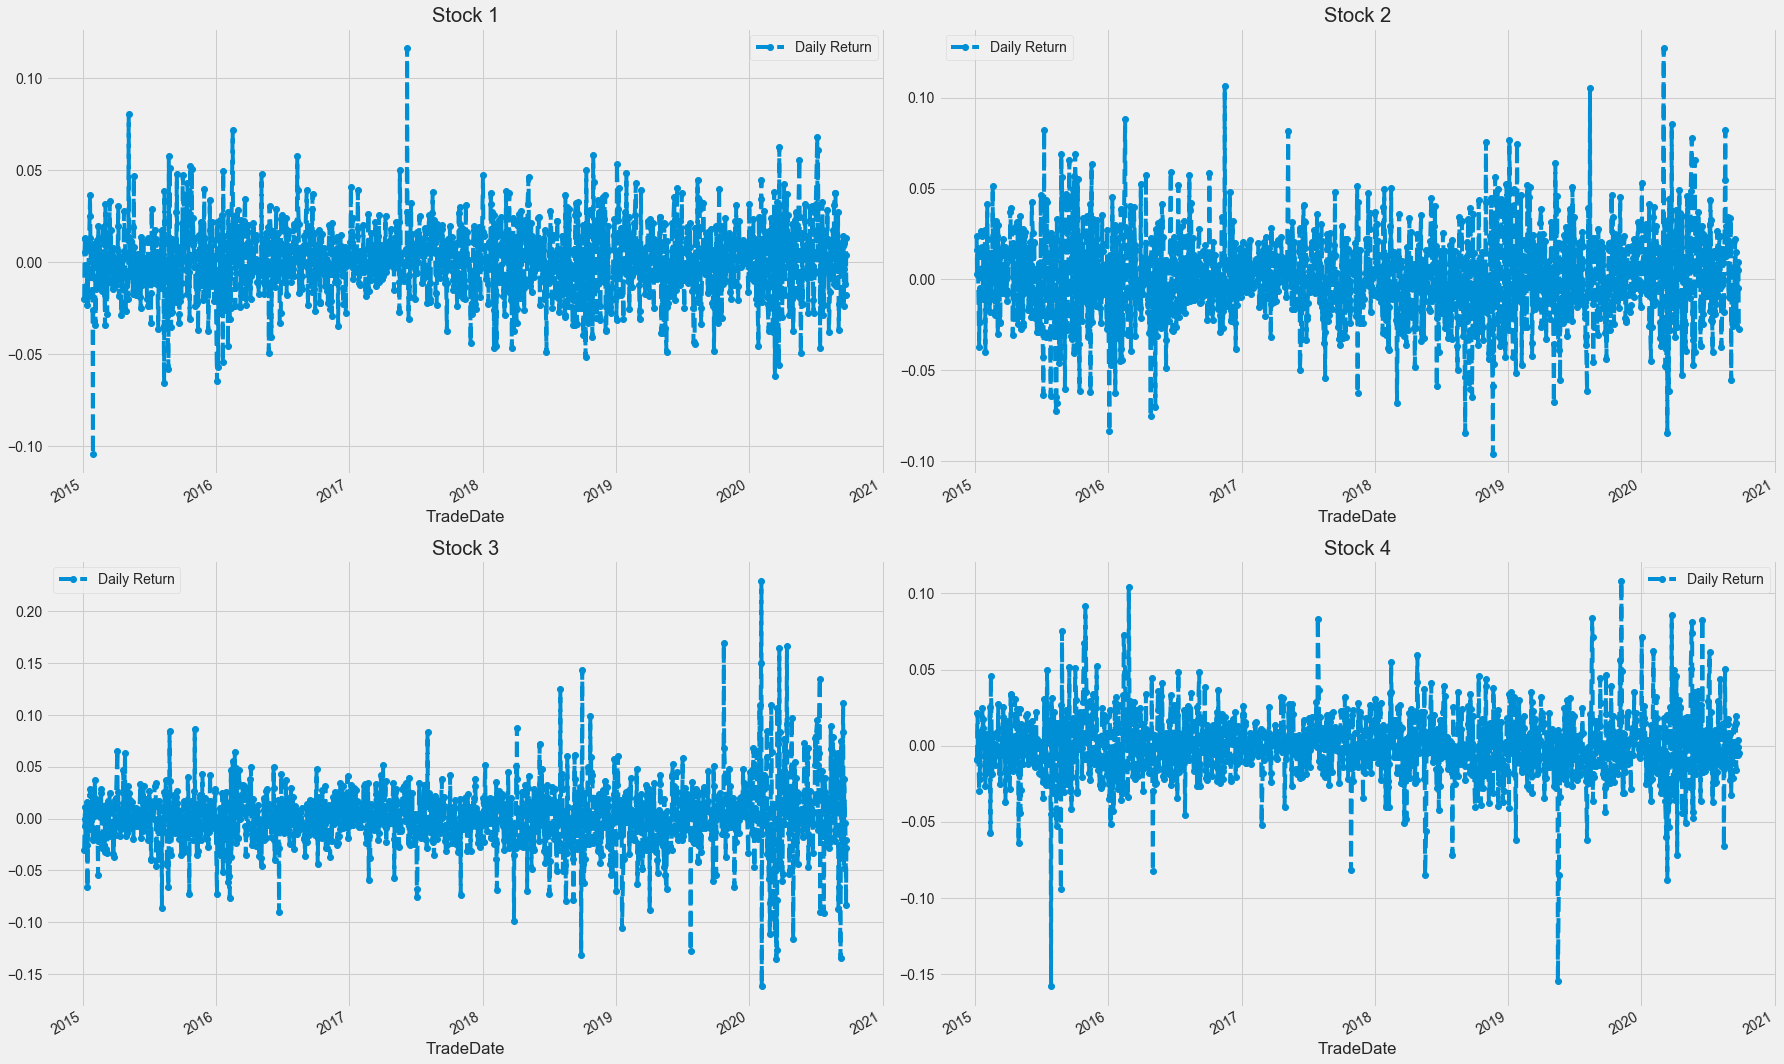

In [31]:
# use pct_change to find the percent change for each day
for company in top4_list:
    company['Daily Return'] = company['VWAP'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(25)

alibaba['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('Stock 1')

jd['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('Stock 2')

tesla['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('Stock 3')

baidu['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('Stock 4')

fig.tight_layout()

C:\Users\junkeat.teo\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


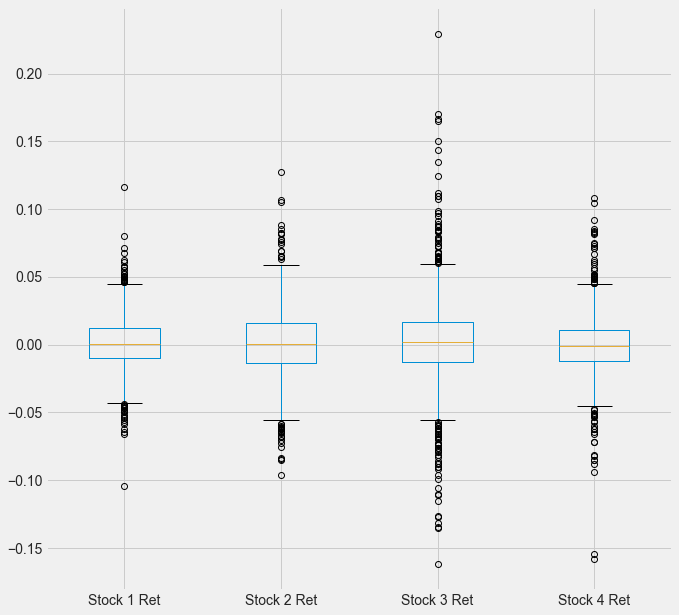

In [143]:
box_df = pd.concat([alibaba['Daily Return'], jd['Daily Return'], tesla['Daily Return'], baidu['Daily Return']], axis = 1)
box_df.columns = ['Stock 1 Ret', 'Stock 2 Ret', 'Stock 3 Ret', 'Stock 4 Ret']
box_df.plot(kind='box', figsize = (10,10));

Kurtosis of Stock 1 : 2.0595733156031892
Kurtosis of Stock 2 : 1.6520424448290232
Kurtosis of Stock 3 : 6.333082931575514
Kurtosis of Stock 4 : 6.1470177326478295


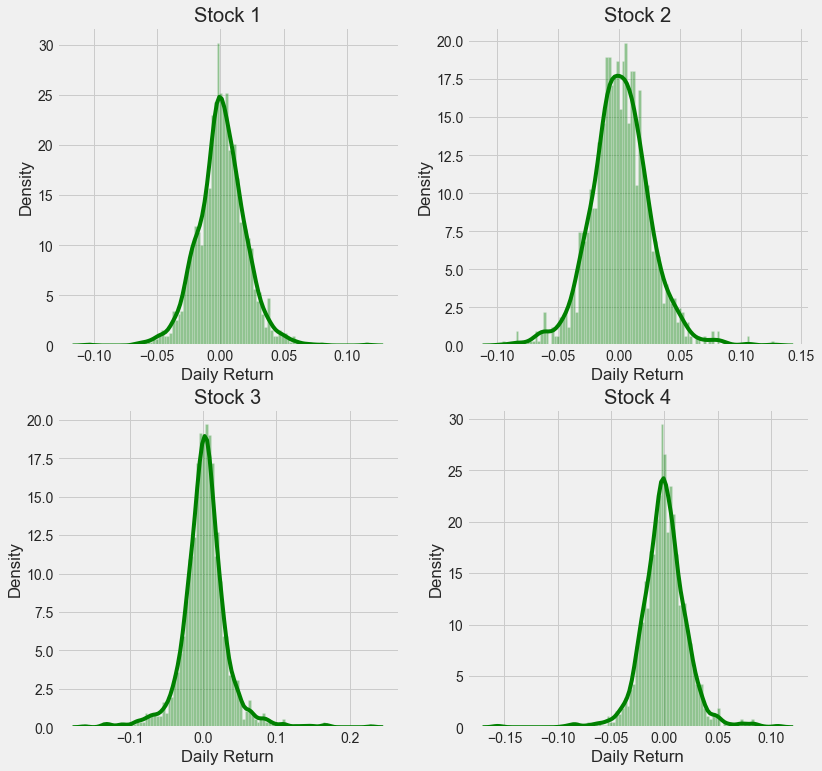

In [32]:
# Note the use of dropna() here, otherwise the NaN values can't be read by seaborn
plt.figure(figsize=(12, 12))

for i, company in enumerate(top4_list, 1):
    plt.subplot(2, 2, i)
    sns.distplot(company['Daily Return'].dropna(), bins=100, color='green')
    plt.ylabel('Density')
    plt.title(f'{tech_list[i - 1]}')
    print('Kurtosis of', tech_list[i-1], ':' , company['Daily Return'].kurtosis())
# Could have also done:
#alibaba['Daily Return'].hist()

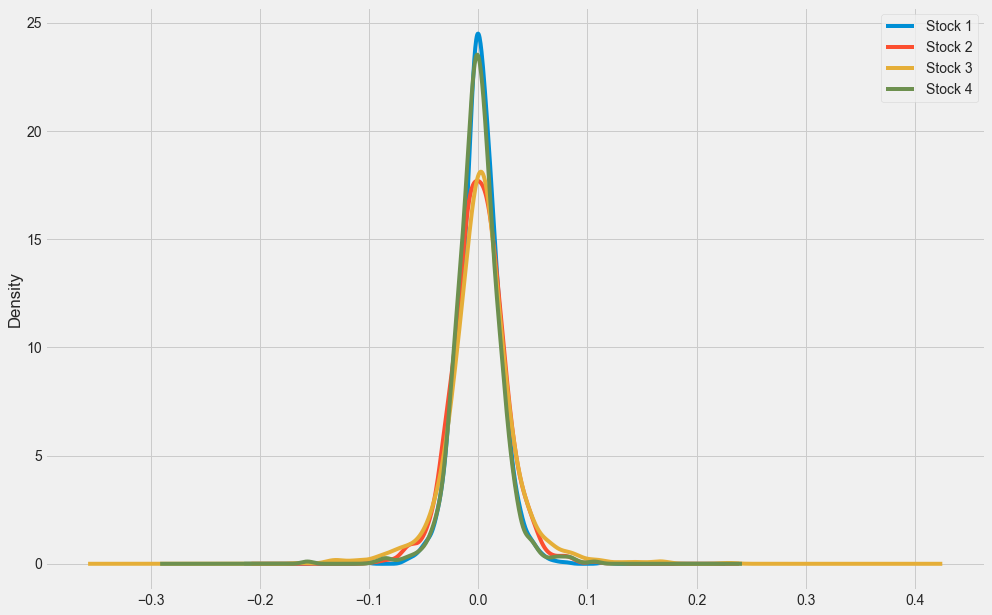

In [141]:
alibaba['Daily Return'].plot(kind='kde', label = 'Stock 1', figsize=(15,10))
jd['Daily Return'].plot(kind='kde', label = 'Stock 2', figsize=(15,10))
tesla['Daily Return'].plot(kind='kde', label = 'Stock 3', figsize=(15,10))
baidu['Daily Return'].plot(kind='kde', label = 'Stock 4', figsize=(15,10))

plt.legend();

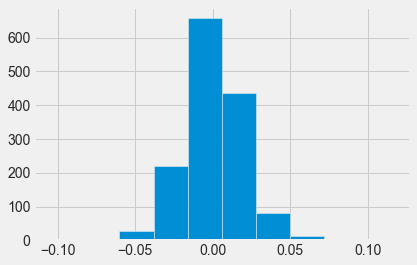

In [33]:
alibaba['Daily Return'].hist()

In [34]:
df_filter_name_vwap = df[['StockName','VWAP']]
df_filter_name_vwap.replace('ALIBABA GROUP HOLDING LTD', 'Stock 1', inplace=True)
df_filter_name_vwap.replace('JD.COM INC', 'Stock 2', inplace=True)
df_filter_name_vwap.replace('TESLA MOTORS INC', 'Stock 3', inplace=True)
df_filter_name_vwap.replace('BAIDU INC', 'Stock 4', inplace=True)
df_filter_name_vwap.reset_index(inplace=True)
df_pivot = df_filter_name_vwap.pivot(index='TradeDate', columns='StockName', values='VWAP')
df_pivot

C:\Users\junkeat.teo\Anaconda3\lib\site-packages\pandas\core\frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


StockName,Stock 1,Stock 2,Stock 3,Stock 4
TradeDate,,,,
2015-01-02,103.38381,23.899308,43.435722,224.03310
2015-01-05,101.30961,24.466599,42.138120,221.99271
2015-01-06,101.83741,24.542008,41.847282,220.03330
2015-01-07,103.11051,24.932496,42.324962,224.71711
2015-01-08,104.44220,24.989502,42.327742,229.40261
...,...,...,...,...
2020-09-18,273.22315,74.526093,441.772470,124.01000
2020-09-21,269.97584,74.176804,439.711430,123.25640
2020-09-22,273.44996,74.885697,427.236090,123.67450


In [35]:
df_pivot_daily_return = df_pivot.pct_change()
df_pivot_daily_return

StockName,Stock 1,Stock 2,Stock 3,Stock 4
TradeDate,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,-0.020063,0.023737,-0.029874,-0.009108
2015-01-06,0.005210,0.003082,-0.006902,-0.008826
2015-01-07,0.012501,0.015911,0.011415,0.021287
2015-01-08,0.012915,0.002286,0.000066,0.020851
...,...,...,...,...
2020-09-18,-0.003742,0.008953,0.038034,-0.001564
2020-09-21,-0.011885,-0.004687,-0.004665,-0.006077
2020-09-22,0.012868,0.009557,-0.028372,0.003392


In [175]:
# Skewness 

df_pivot_daily_return_before = df_pivot_daily_return[df_pivot_daily_return.index < '2019-12-19']
print( 'Stock 1 Skewness (before)  =', df_pivot_daily_return_before['Stock 1'].skew())
print( 'Stock 1 Skewness (overall)  =', df_pivot_daily_return['Stock 1'].skew())
print(' ')
print( 'Stock 2 Skewness (before)  =', df_pivot_daily_return_before['Stock 2'].skew())
print( 'Stock 2 Skewness (overall)  =', df_pivot_daily_return['Stock 2'].skew())
print(' ')
print( 'Stock 3 Skewness (before)  =', df_pivot_daily_return_before['Stock 3'].skew())
print( 'Stock 3 Skewness (overall)  =', df_pivot_daily_return['Stock 3'].skew())
print(' ')
print( 'Stock 4 Skewness (before)  =', df_pivot_daily_return_before['Stock 4'].skew())
print( 'Stock 4 Skewness (overall)  =', df_pivot_daily_return['Stock 4'].skew())

Stock 1 Skewness (before)  = 0.10457898040344653
Stock 1 Skewness (overall)  = 0.08266270819109121
 
Stock 2 Skewness (before)  = 0.08638399022016736
Stock 2 Skewness (overall)  = 0.16615185020235115
 
Stock 3 Skewness (before)  = -0.026659673524272263
Stock 3 Skewness (overall)  = 0.36742169721381185
 
Stock 4 Skewness (before)  = -0.4568824856082785
Stock 4 Skewness (overall)  = -0.27421268416794253


In [176]:
# Kurtosis

print( 'Stock 1 Kurtosis (before 2019)  =', df_pivot_daily_return_before['Stock 1'].kurt())
print( 'Stock 1 Kurtosis (overall) =', df_pivot_daily_return['Stock 1'].kurt())
print(' ')
print( 'Stock 2 Kurtosis (before 2019)  =', df_pivot_daily_return_before['Stock 2'].kurt())
print( 'Stock 2 Kurtosis (overall) =', df_pivot_daily_return['Stock 2'].kurt())
print(' ')
print( 'Stock 3 Kurtosis (before 2019)  =', df_pivot_daily_return_before['Stock 3'].kurt())
print( 'Stock 3 Kurtosis (overall) =', df_pivot_daily_return['Stock 3'].kurt())
print(' ')
print( 'Stock 4 Kurtosis (before 2019)  =', df_pivot_daily_return_before['Stock 4'].kurt())
print( 'Stock 4 Kurtosis (overall) =', df_pivot_daily_return['Stock 4'].kurt())

Stock 1 Kurtosis (before 2019)  = 2.472970733357166
Stock 1 Kurtosis (overall) = 2.0595733156031892
 
Stock 2 Kurtosis (before 2019)  = 1.4552354740334712
Stock 2 Kurtosis (overall) = 1.658514144241602
 
Stock 3 Kurtosis (before 2019)  = 4.718649782157752
Stock 3 Kurtosis (overall) = 6.4377645774259085
 
Stock 4 Kurtosis (before 2019)  = 7.527222007438837
Stock 4 Kurtosis (overall) = 6.256000891521928


In [191]:
# value at risk
print('Stock 1')
print( 'Before 2019-12-19:')
print( 'Historical VaR at 1 days at 95%  =', df_pivot_daily_return_before['Stock 1'].sort_values().quantile(0.05))
print( 'Historical Mirror VaR at 1 days at 5%  =', df_pivot_daily_return_before['Stock 1'].sort_values().quantile(0.95))
print(' ')
print( 'Overall:')
print( 'Historical VaR at 1 days at 95%  =', df_pivot_daily_return['Stock 1'].sort_values().quantile(0.05))
print( 'Historical Mirror VaR at 1 days at 5%  =', df_pivot_daily_return['Stock 1'].sort_values().quantile(0.95))
print(' ')

print('Stock 2')
print( 'Before 2019-12-19:')
print( 'Historical VaR at 1 days at 95%  =', df_pivot_daily_return_before['Stock 2'].sort_values().quantile(0.05))
print( 'Historical Mirror VaR at 1 days at 5%  =', df_pivot_daily_return_before['Stock 2'].sort_values().quantile(0.95))
print(' ')
print( 'Overall:')
print( 'Historical VaR at 1 days at 95%  =', df_pivot_daily_return['Stock 2'].sort_values().quantile(0.05))
print( 'Historical Mirror VaR at 1 days at 5%  =', df_pivot_daily_return['Stock 2'].sort_values().quantile(0.95))
print(' ')

print('Stock 3')
print( 'Before 2019-12-19:')
print( 'Historical VaR at 1 days at 95%  =', df_pivot_daily_return_before['Stock 3'].sort_values().quantile(0.05))
print( 'Historical Mirror VaR at 1 days at 5%  =', df_pivot_daily_return_before['Stock 3'].sort_values().quantile(0.95))
print(' ')
print( 'Overall:')
print( 'Historical VaR at 1 days at 95%  =', df_pivot_daily_return['Stock 3'].sort_values().quantile(0.05))
print( 'Historical Mirror VaR at 1 days at 5%  =', df_pivot_daily_return['Stock 3'].sort_values().quantile(0.95))
print(' ')

print('Stock 4')
print( 'Before 2019-12-19:')
print( 'Historical VaR at 1 days at 95%  =', df_pivot_daily_return_before['Stock 4'].sort_values().quantile(0.05))
print( 'Historical Mirror VaR at 1 days at 5%  =', df_pivot_daily_return_before['Stock 4'].sort_values().quantile(0.95))
print(' ')
print( 'Overall:')
print( 'Historical VaR at 1 days at 95%  =', df_pivot_daily_return['Stock 4'].sort_values().quantile(0.05))
print( 'Historical Mirror VaR at 1 days at 5%  =', df_pivot_daily_return['Stock 4'].sort_values().quantile(0.95))
print(' ')


Stock 1
Before 2019-12-19:
Historical VaR at 1 days at 95%  = -0.0281763516829709
Historical Mirror VaR at 1 days at 5%  = 0.030532778016836334
 
Overall:
Historical VaR at 1 days at 95%  = -0.02898815723616115
Historical Mirror VaR at 1 days at 5%  = 0.03160412853714572
 
Stock 2
Before 2019-12-19:
Historical VaR at 1 days at 95%  = -0.035981099383853965
Historical Mirror VaR at 1 days at 5%  = 0.04023792731086784
 
Overall:
Historical VaR at 1 days at 95%  = -0.036840350964440716
Historical Mirror VaR at 1 days at 5%  = 0.04127418531775141
 
Stock 3
Before 2019-12-19:
Historical VaR at 1 days at 95%  = -0.03897680823316696
Historical Mirror VaR at 1 days at 5%  = 0.03806217542862922
 
Overall:
Historical VaR at 1 days at 95%  = -0.0436833691063934
Historical Mirror VaR at 1 days at 5%  = 0.048047051797354974
 
Stock 4
Before 2019-12-19:
Historical VaR at 1 days at 95%  = -0.029532020326617326
Historical Mirror VaR at 1 days at 5%  = 0.03122186986794248
 
Overall:
Historical VaR at 1 

In [194]:
std = np.std(df_pivot_daily_return)
mean = np.mean(df_pivot_daily_return)
std

StockName
Stock 1    0.019230
Stock 2    0.024451
Stock 3    0.031377
Stock 4    0.021621
dtype: float64

In [196]:
# simulating value at risk at N days
horizon = 30
nbr_simulation = 10000

std = np.std(df_pivot_daily_return['Stock 1'])
mean = np.mean(df_pivot_daily_return['Stock 1'])

gen = 1 + mean + std * np.random.randn(nbr_simulation, horizon) 
gen = np.prod(gen,axis=1) - 1 
gen.sort()

print('Stock 1')
print('Mean of daily return = {}'.format(mean))
print('Standard deviation of daily return = {}'.format(std))
print( 'VaR at {} days at 95%  = {}'.format(horizon,np.quantile(gen, 0.05)))
print( 'Mirror VaR at {} days at 5%  = {}'.format(horizon,np.quantile(gen, 0.95)))



Stock 1
Mean of daily return = 0.0008494118855958461
Standard deviation of daily return = 0.019229990062575423
VaR at 30 days at 95%  = -0.14279782139187522
Mirror VaR at 30 days at 95%  = 0.2116756350194635


In [200]:
# simulating value at risk at N days
horizon = 30
nbr_simulation = 10000

std = np.std(df_pivot_daily_return['Stock 2'])
mean = np.mean(df_pivot_daily_return['Stock 2'])

gen = 1 + mean + std * np.random.randn(nbr_simulation, horizon) 
gen = np.prod(gen,axis=1) - 1 
gen.sort()

print('Stock 2')
print('Mean of daily return = {}'.format(mean))
print('Standard deviation of daily return = {}'.format(std))
print( 'VaR at {} days at 95%  = {}'.format(horizon,np.quantile(gen, 0.05)))
print( 'Mirror VaR at {} days at 5%  = {}'.format(horizon,np.quantile(gen, 0.95)))

Stock 2
Mean of daily return = 0.0010748642164610611
Standard deviation of daily return = 0.024450957482247303
VaR at 30 days at 95%  = -0.17947639715997304
Mirror VaR at 30 days at 95%  = 0.27247383975759787


In [198]:
# simulating value at risk at N days
horizon = 30
nbr_simulation = 10000

std = np.std(df_pivot_daily_return['Stock 3'])
mean = np.mean(df_pivot_daily_return['Stock 3'])

gen = 1 + mean + std * np.random.randn(nbr_simulation, horizon) 
gen = np.prod(gen,axis=1) - 1 
gen.sort()

print('Stock 3')
print('Mean of daily return = {}'.format(mean))
print('Standard deviation of daily return = {}'.format(std))
print( 'VaR at {} days at 95%  = {}'.format(horizon,np.quantile(gen, 0.05)))
print( 'Mirror VaR at {} days at 5%  = {}'.format(horizon,np.quantile(gen, 0.95)))

Stock 3
Mean of daily return = 0.002001484051867853
Standard deviation of daily return = 0.031377385993498194
VaR at 30 days at 95%  = -0.20785641880540895
Mirror VaR at 30 days at 95%  = 0.38833797389271163


In [199]:
# simulating value at risk at N days
horizon = 30
nbr_simulation = 10000

std = np.std(df_pivot_daily_return['Stock 4'])
mean = np.mean(df_pivot_daily_return['Stock 4'])

gen = 1 + mean + std * np.random.randn(nbr_simulation, horizon) 
gen = np.prod(gen,axis=1) - 1 
gen.sort()

print('Stock 4')
print('Mean of daily return = {}'.format(mean))
print('Standard deviation of daily return = {}'.format(std))
print( 'VaR at {} days at 95%  = {}'.format(horizon,np.quantile(gen, 0.05)))
print( 'Mirror VaR at {} days at 5%  = {}'.format(horizon,np.quantile(gen, 0.95)))



Stock 4
Mean of daily return = -0.00018096043143148548
Standard deviation of daily return = 0.02162077657560728
VaR at 30 days at 95%  = -0.18475602703632002
Mirror VaR at 30 days at 95%  = 0.19805804399979518


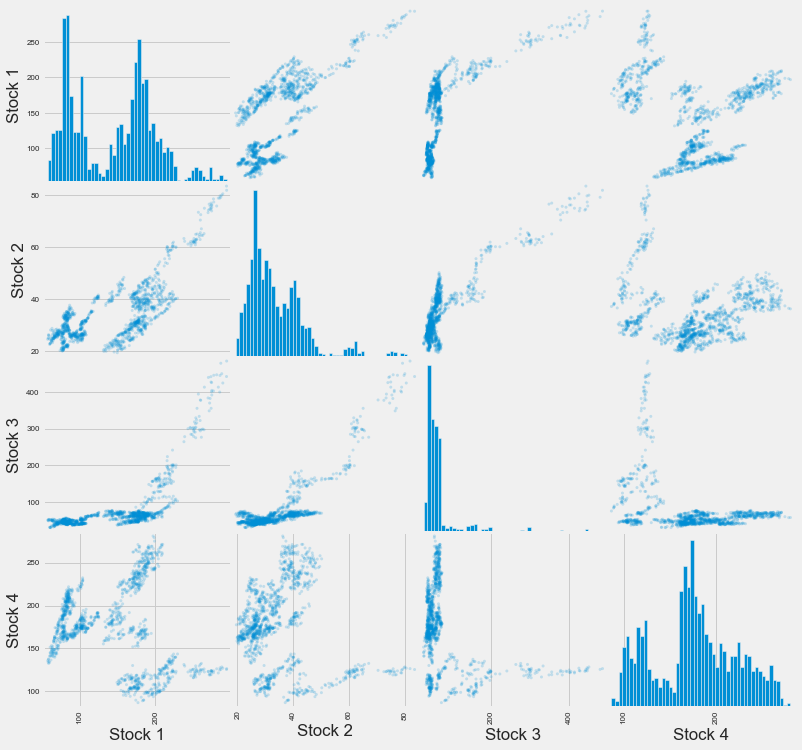

In [137]:
from pandas.plotting import scatter_matrix 

scatter_matrix(df_pivot, figsize =(12, 12), alpha = 0.2, hist_kwds={'bins':50});

C:\Users\junkeat.teo\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


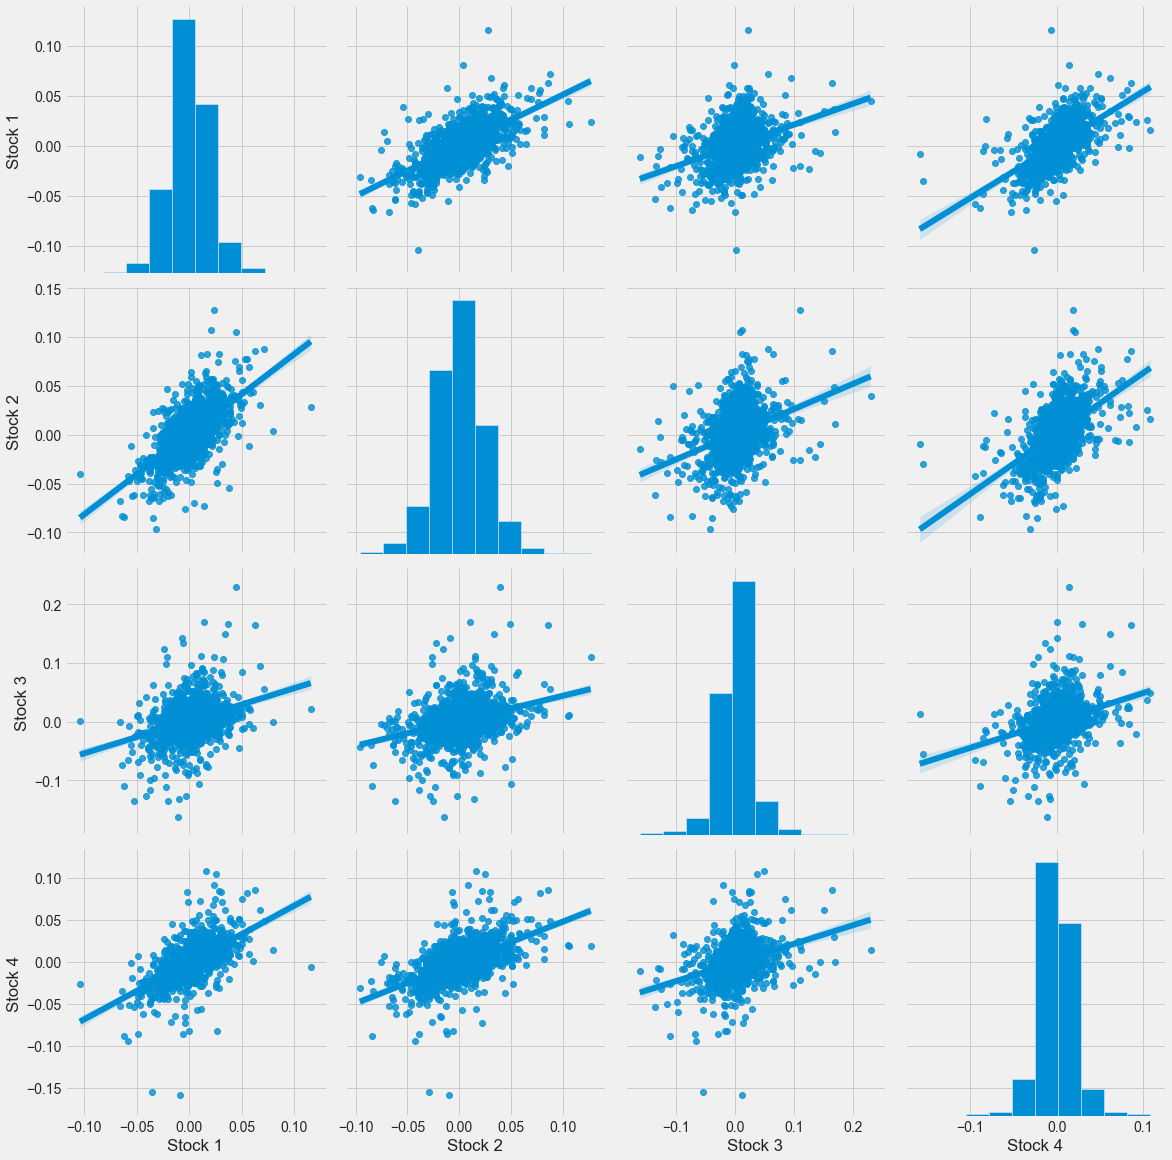

In [36]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis 
# of all the comparisons

sns.pairplot(df_pivot_daily_return, kind='reg', height=4, size=4)

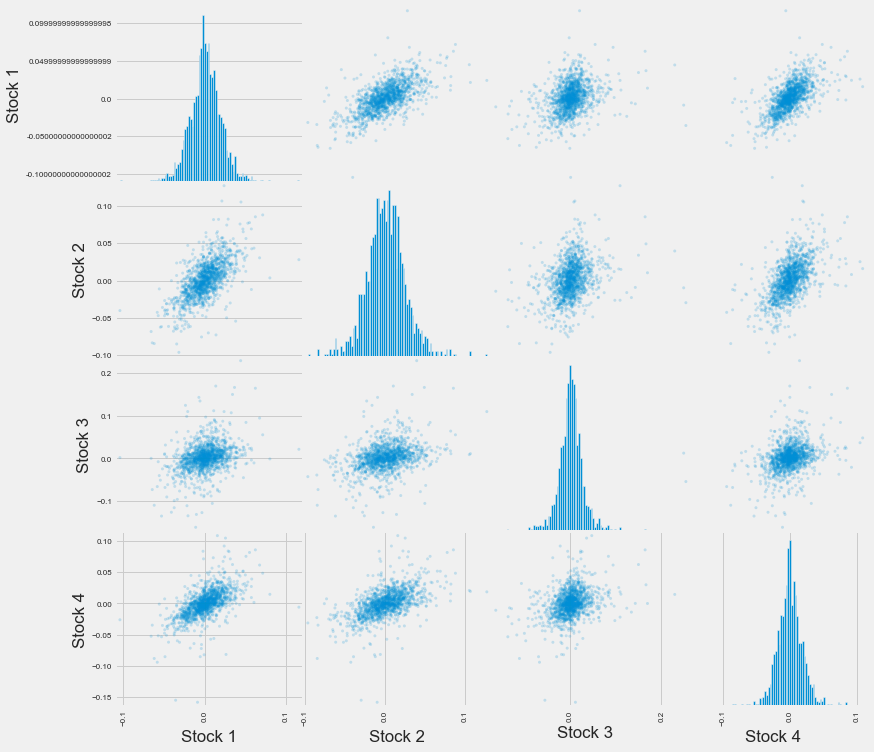

In [159]:
scatter_matrix(df_pivot_daily_return, figsize=(12,12), alpha = 0.2, hist_kwds={'bins':100});

C:\Users\junkeat.teo\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1264: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


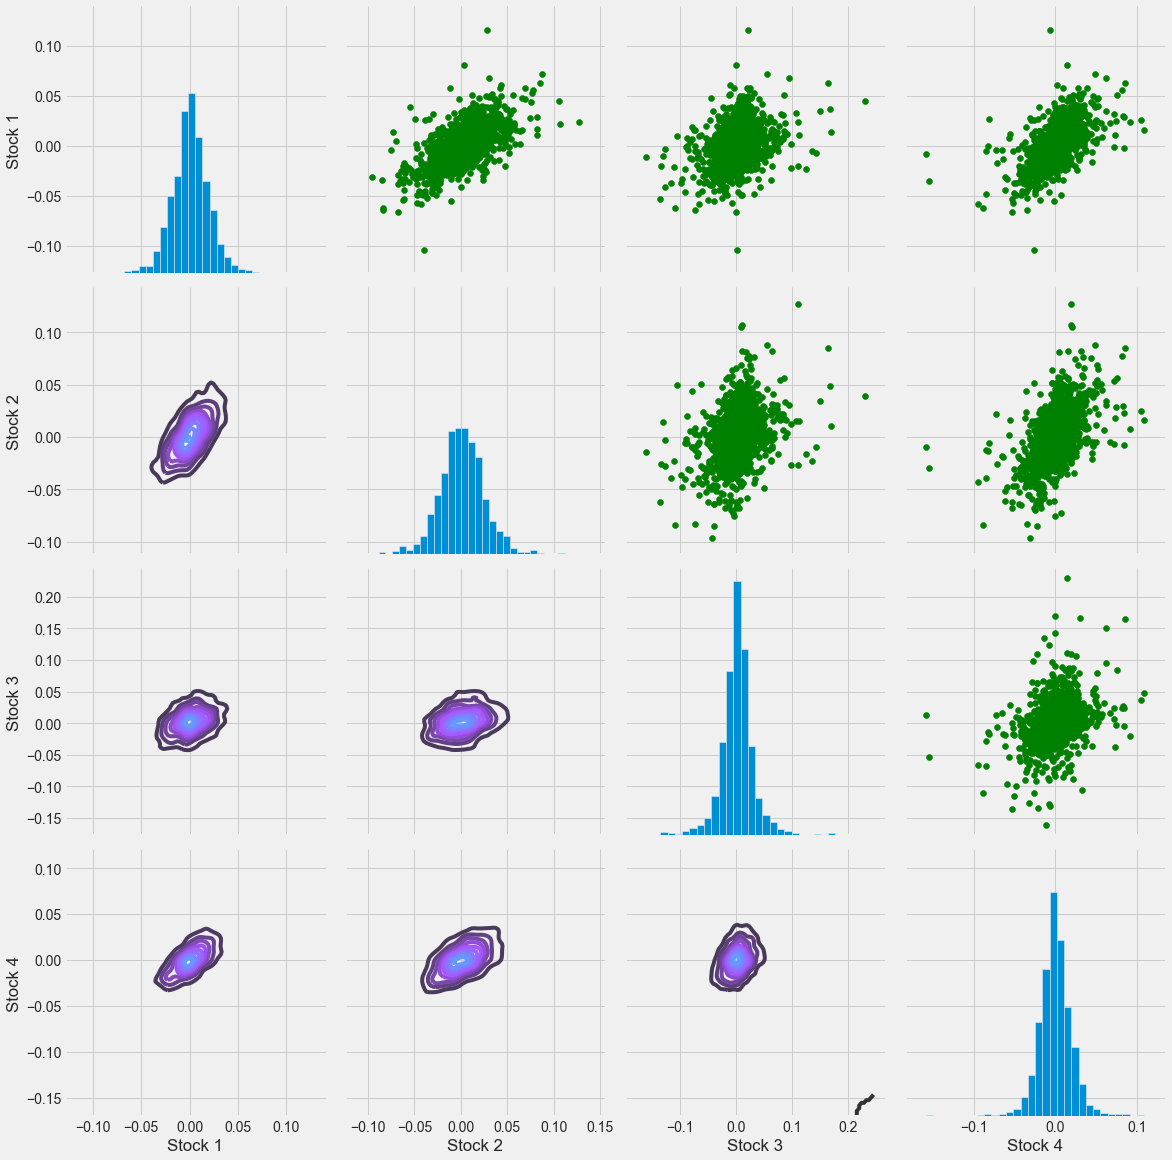

In [37]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(df_pivot_daily_return.dropna(), height=4, size=4)

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='green')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

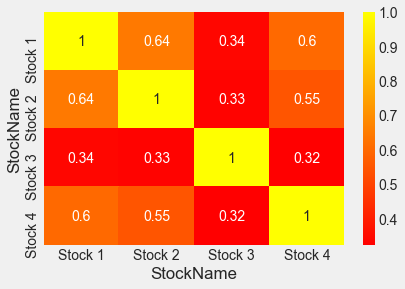

In [38]:
sns.heatmap(df_pivot_daily_return.corr(), annot=True, cmap='autumn')

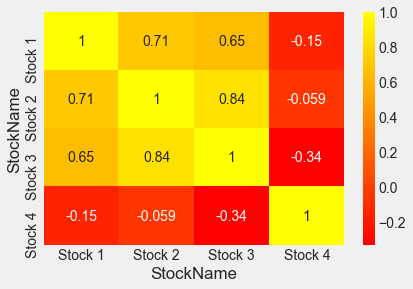

In [39]:
sns.heatmap(df_pivot.corr(), annot=True, cmap='autumn')

In [160]:
df_pivot_daily_return

StockName,Stock 1,Stock 2,Stock 3,Stock 4
TradeDate,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,-0.020063,0.023737,-0.029874,-0.009108
2015-01-06,0.005210,0.003082,-0.006902,-0.008826
2015-01-07,0.012501,0.015911,0.011415,0.021287
2015-01-08,0.012915,0.002286,0.000066,0.020851
...,...,...,...,...
2020-09-18,-0.003742,0.008953,0.038034,-0.001564
2020-09-21,-0.011885,-0.004687,-0.004665,-0.006077
2020-09-22,0.012868,0.009557,-0.028372,0.003392


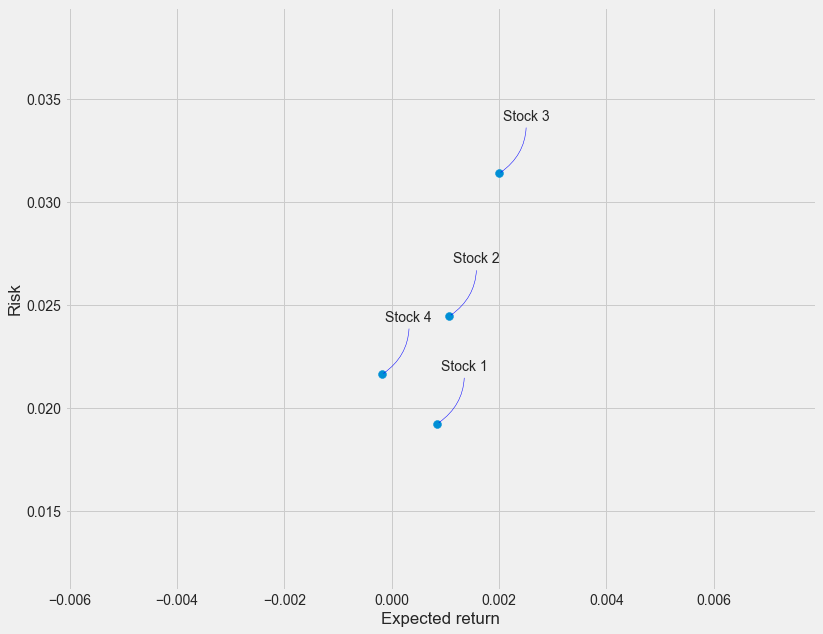

In [40]:
# Let's start by defining a new DataFrame as a clenaed version of the oriignal tech_rets DataFrame
rets = df_pivot_daily_return.dropna()

area = np.pi*20

plt.figure(figsize=(12, 10))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

In [228]:
tesla[['VWAP']]

,VWAP
TradeDate,
2015-01-02,43.435722
2015-01-05,42.138120
2015-01-06,41.847282
2015-01-07,42.324962
2015-01-08,42.327742
...,...
2020-09-18,441.772470
2020-09-21,439.711430
2020-09-22,427.236090


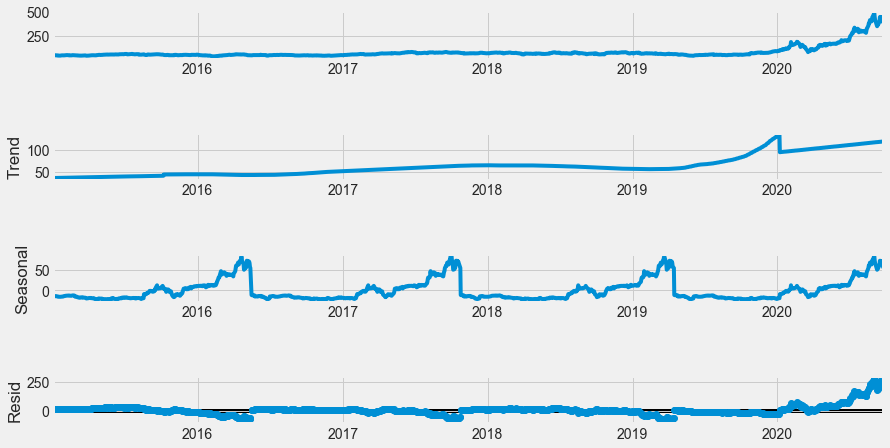

In [233]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq', period=365)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
seasonal_decompose(tesla[['VWAP']])

C:\Users\junkeat.teo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\junkeat.teo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


The Root Mean Squared Error of our forecasts with auto optimization is 27549.


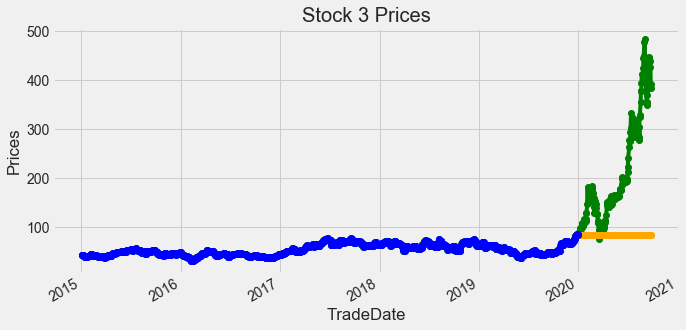

In [292]:
# Simple Exponential Smoothing (SES)
## auto optimization
tesla[['VWAP']].plot(marker='o', color='green', figsize=(10, 5))
fit2 = SimpleExpSmoothing(train_data_3['VWAP']).fit()
fcast2 = fit2.forecast(185).rename(r'$\alpha={}$'.format(0.8))
fcast2.index = test_data_3.index
# plot
fcast2.plot(marker='o', color='orange', legend=True)
fit2.fittedvalues.plot(marker='o', color='blue')
plt.title('Stock 3 Prices')
plt.ylabel('Prices')

mse2 = mean_squared_error(fcast2, test_data_3['VWAP'])
#mse2 = ((fcast2 - test_data_3['VWAP']) ** 2).mean()
print('The Root Mean Squared Error of our forecasts with auto optimization is {}.'.format(round(mse2)))
plt.legend().remove()
plt.show()

In [291]:
# report performance
mse = mean_squared_error(test_data_3['VWAP'], fcast2)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_3['VWAP'], fcast2)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data_3['VWAP'], fcast2))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fcast2 - test_data_3['VWAP'])/np.abs(test_data_3['VWAP']))
print('MAPE: '+str(mape))

MSE: 27548.526706086286
MAE: 126.89179824864864
RMSE: 165.9774885521717
MAPE: 0.5020841272686991


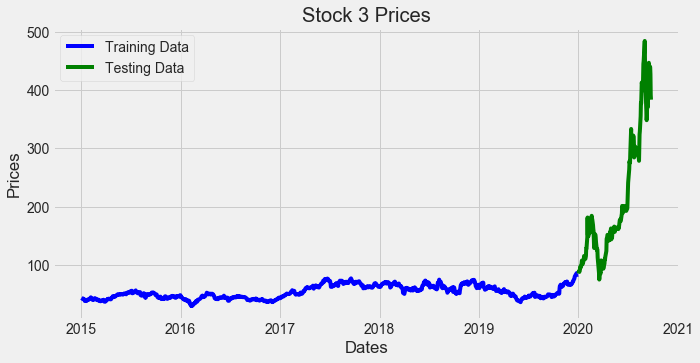

In [41]:
#Arima

train_data_3, test_data_3 = tesla[0:int(len(tesla)*0.871)], tesla[int(len(tesla)*0.871):]
plt.figure(figsize=(10,5))
plt.title('Stock 3 Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data_3['VWAP'], 'blue', label='Training Data')
plt.plot(test_data_3['VWAP'], 'green', label='Testing Data')
#plt.xticks(np.arange(0,1427, 200), tesla['TradeDate'][0:1427:200])
plt.legend()

In [209]:
model_autoARIMA = auto_arima(train_data_3['VWAP'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, start_Q=0,
                      max_P=5, max_Q=5,
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4379.363, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4352.942, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4353.775, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4378.009, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4354.941, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4354.941, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4355.999, Time=1.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4351.414, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4353.414, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4353.414, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4352.276, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4355.409, Time=0.17 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.275 seconds
                               SARIMAX Results                                
Dep. Vari

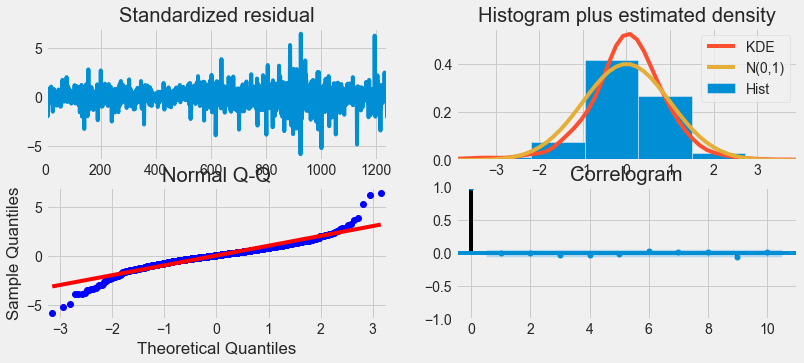

In [43]:
model_autoARIMA.plot_diagnostics(figsize=(12,5))
plt.show()

In [44]:
model = ARIMA(train_data_3['VWAP'], order=(1, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.VWAP   No. Observations:                 1241
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2173.471
Method:                       css-mle   S.D. of innovations              1.394
Date:                Mon, 08 Mar 2021   AIC                           4352.942
Time:                        16:36:47   BIC                           4368.313
Sample:                             1   HQIC                          4358.723
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0320      0.047      0.687      0.492      -0.059       0.123
ar.L1.D.VWAP     0.1505      0.028      5.362      0.000       0.095       0.205
                                    Roots   

C:\Users\junkeat.teo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\junkeat.teo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


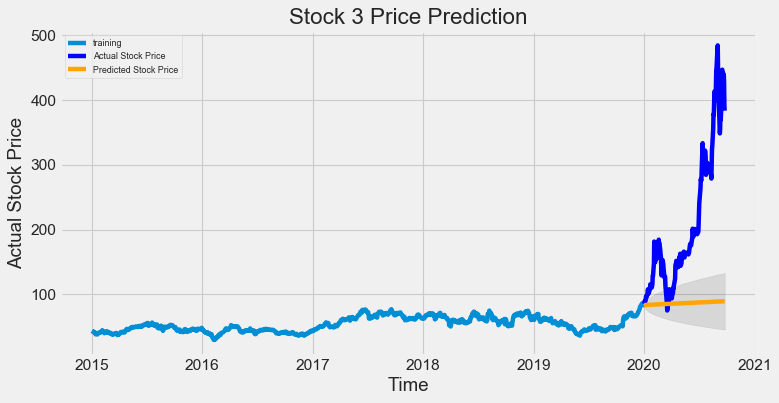

In [45]:
# Forecast
fc, se, conf = fitted.forecast(185, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data_3.index)
lower_series = pd.Series(conf[:, 0], index=test_data_3.index)
upper_series = pd.Series(conf[:, 1], index=test_data_3.index)
plt.figure(figsize=(10,5), dpi=80)
plt.plot(train_data_3['VWAP'], label='training')
plt.plot(test_data_3['VWAP'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock 3 Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [46]:
# report performance
mse = mean_squared_error(test_data_3['VWAP'], fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_3['VWAP'], fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data_3['VWAP'], fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data_3['VWAP'])/np.abs(test_data_3['VWAP']))
print('MAPE: '+str(mape))

MSE: 26476.24238757815
MAE: 123.92927509645811
RMSE: 162.7152186723115
MAPE: 0.48853684247314005


Stock 2 ARIMA

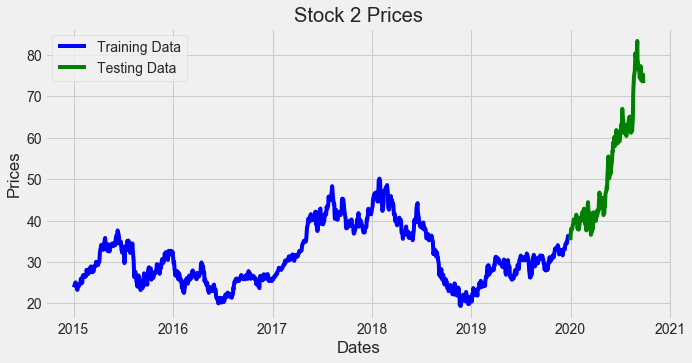

In [47]:
train_data_2, test_data_2 = jd[0:int(len(jd)*0.871)], jd[int(len(jd)*0.871):]
plt.figure(figsize=(10,5))
plt.title('Stock 2 Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data_2['VWAP'], 'blue', label='Training Data')
plt.plot(test_data_2['VWAP'], 'green', label='Testing Data')
#plt.xticks(np.arange(0,1427, 200), tesla['TradeDate'][0:1427:200])
plt.legend()

In [289]:
model_autoARIMA_2 = auto_arima(train_data_2['VWAP'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, start_Q=0,
                      max_P=5, max_Q=5,
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA_2.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2753.569, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2742.858, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2742.014, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2751.775, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2743.342, Time=0.67 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2743.211, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2743.311, Time=1.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2740.184, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2741.518, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2741.390, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2741.027, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2741.532, Time=0.45 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.093 seconds
                               SARIMAX Results                                
Dep. Vari

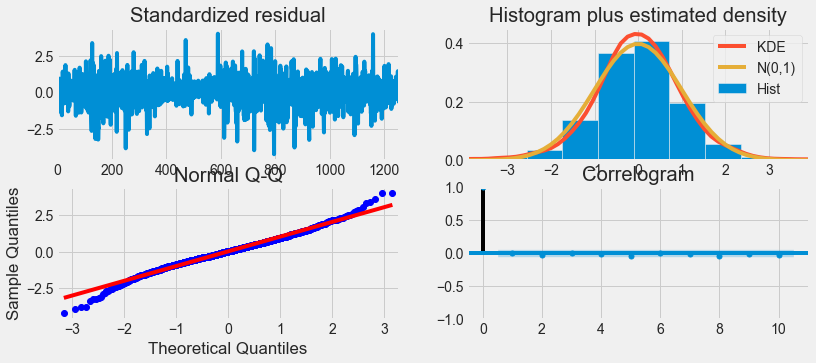

In [290]:
model_autoARIMA_2.plot_diagnostics(figsize=(12,5))
plt.show()

In [50]:
model = ARIMA(train_data_2['VWAP'], order=(0, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.VWAP   No. Observations:                 1254
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1368.007
Method:                       css-mle   S.D. of innovations              0.720
Date:                Mon, 08 Mar 2021   AIC                           2742.014
Time:                        16:36:59   BIC                           2757.416
Sample:                             1   HQIC                          2747.803
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0093      0.023      0.412      0.680      -0.035       0.053
ma.L1.D.VWAP     0.1070      0.029      3.715      0.000       0.051       0.163
                                    Roots   

C:\Users\junkeat.teo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\junkeat.teo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


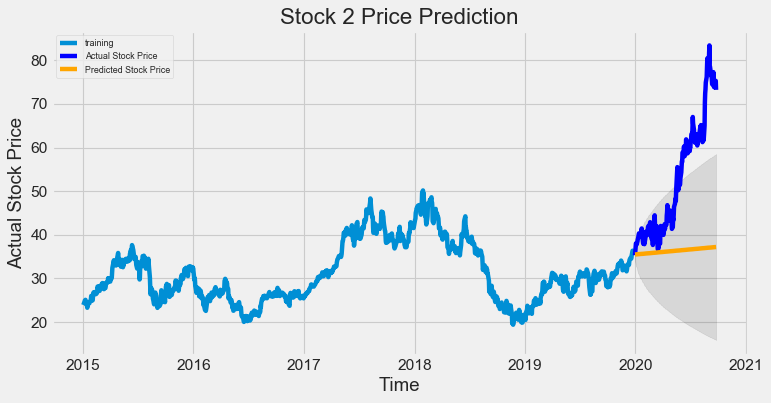

In [51]:
# Forecast
fc, se, conf = fitted.forecast(186, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data_2.index)
lower_series = pd.Series(conf[:, 0], index=test_data_2.index)
upper_series = pd.Series(conf[:, 1], index=test_data_2.index)
plt.figure(figsize=(10,5), dpi=80)
plt.plot(train_data_2['VWAP'], label='training')
plt.plot(test_data_2['VWAP'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Stock 2 Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [52]:
# report performance
mse = mean_squared_error(test_data_2['VWAP'], fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_2['VWAP'], fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data_2['VWAP'], fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data_2['VWAP'])/np.abs(test_data_2['VWAP']))
print('MAPE: '+str(mape))

MSE: 438.9685564048226
MAE: 16.561841028706564
RMSE: 20.95157646586105
MAPE: 0.273373906467898


LSTM prediction

In [53]:
#Create a new dataframe with only the 'VWAP' column
data_3 = tesla.filter(['VWAP'])
#Convert the dataframe to a numpy array
dataset_3 = data_3.values
#Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset_3) * .871 ))

training_data_len

1243

In [58]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_3 = scaler.fit_transform(dataset_3)

scaled_data_3

array([[0.03056416],
       [0.02771183],
       [0.02707252],
       ...,
       [0.87421681],
       [0.79617963],
       [0.77845485]])

In [59]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data_3[0:int(training_data_len), :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

[array([0.03056416, 0.02771183, 0.02707252, 0.02812254, 0.02812865,
       0.02588099, 0.02356154, 0.02497122, 0.01902389, 0.01967397,
       0.01955417, 0.01867834, 0.02106651, 0.02301226, 0.02363755,
       0.02556859, 0.02569582, 0.02379318, 0.02396644, 0.02513494,
       0.02698644, 0.03039631, 0.03125495, 0.03296533, 0.03136213,
       0.02975511, 0.02773623, 0.02273086, 0.02433213, 0.02448116,
       0.02511379, 0.02730777, 0.02991144, 0.02757383, 0.02491631,
       0.02523966, 0.02631627, 0.02492642, 0.02204881, 0.02220207,
       0.02296373, 0.02414449, 0.02152794, 0.01866164, 0.01899663,
       0.0204468 , 0.0194327 , 0.01800711, 0.02002321, 0.02110585,
       0.02190483, 0.02267907, 0.02183612, 0.02270597, 0.0238193 ,
       0.02083091, 0.01943261, 0.01628547, 0.01778189, 0.01893781])]
[0.01764353401754569]

[array([0.03056416, 0.02771183, 0.02707252, 0.02812254, 0.02812865,
       0.02588099, 0.02356154, 0.02497122, 0.01902389, 0.01967397,
       0.01955417, 0.01867834, 0.02

(1183, 60, 1)

In [62]:
#conda install -c conda-forge tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1183/1183 [==============================] - 45s 35ms/step - loss: 1.7414e-04


In [63]:
#Create the testing data set
#Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data_3[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset_3[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

35.822833266847525

C:\Users\junkeat.teo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


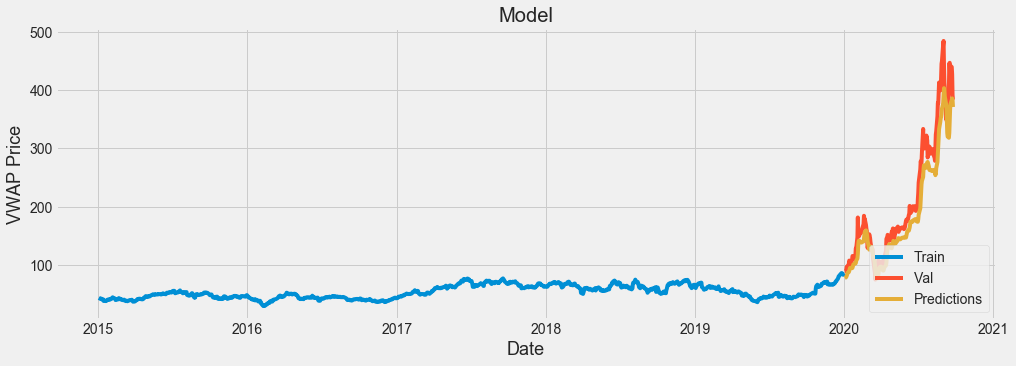

In [64]:
# Plot the data
train = data_3[:training_data_len]
valid = data_3[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(15,5))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('VWAP Price', fontsize=18)
plt.plot(train['VWAP'])
plt.plot(valid[['VWAP', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

C:\Users\junkeat.teo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


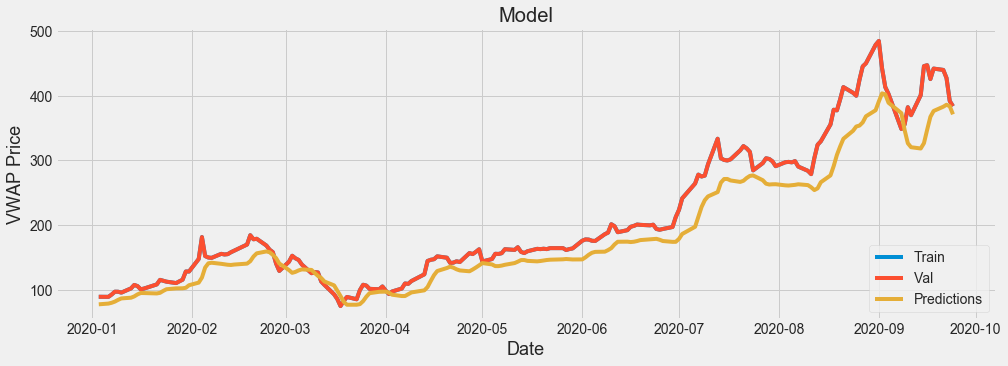

In [65]:
# Plot the data
train = data_3[training_data_len:]
valid = data_3[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(15,5))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('VWAP Price', fontsize=18)
plt.plot(train['VWAP'])
plt.plot(valid[['VWAP', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

ARIMA based on daily prediction

Text(0.5, 1.0, 'Stock 3 Autocorrelation plot')

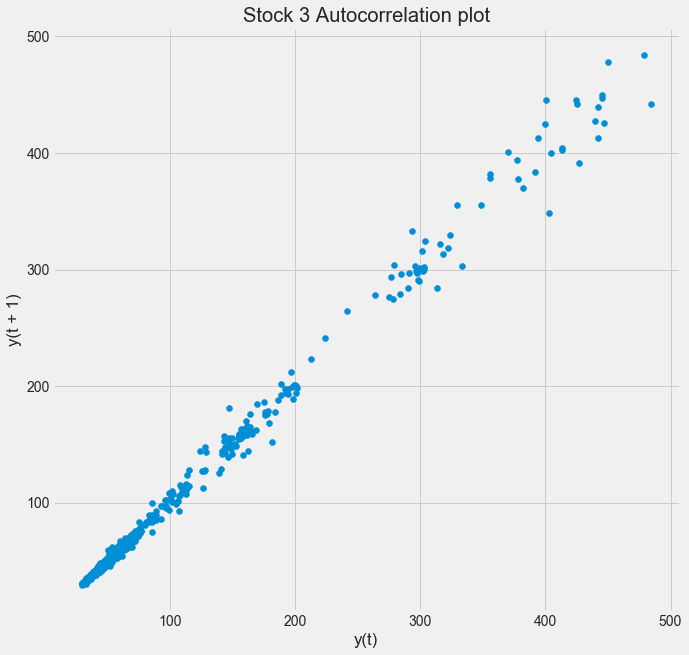

In [105]:
plt.figure(figsize=(10,10))
lag_plot(tesla['VWAP'], lag=1)
plt.title('Stock 3 Autocorrelation plot')

In [106]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [114]:
train_ar = train_data_3['VWAP'].values
test_ar = test_data_3['VWAP'].values

# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)
error3 = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE: %.3f' % error3)

<class 'list'>
Testing Mean Squared Error: 160.418
Symmetric mean absolute percentage error: 51.520


ValueError: operands could not be broadcast together with shapes (185,1) (184,1) 

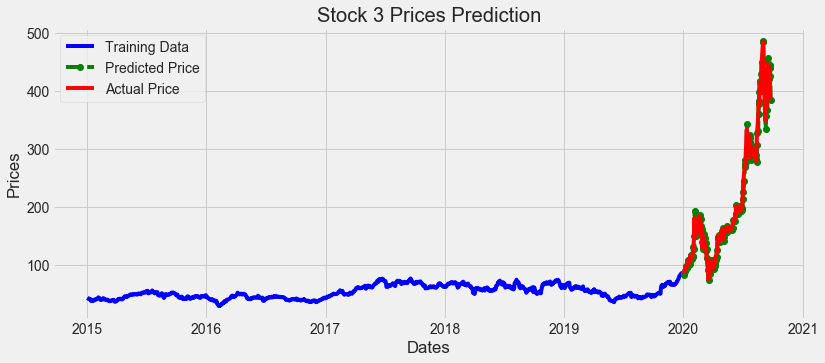

In [113]:
plt.figure(figsize=(12,5))
plt.plot(train_data_3['VWAP'], color='blue', label='Training Data')
plt.plot(test_data_3.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data_3.index, test_data_3['VWAP'], color='red', label='Actual Price')
plt.title('Stock 3 Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.xticks(np.arange(0,1427, 200), df['Date'][0:1427:200])
plt.legend()

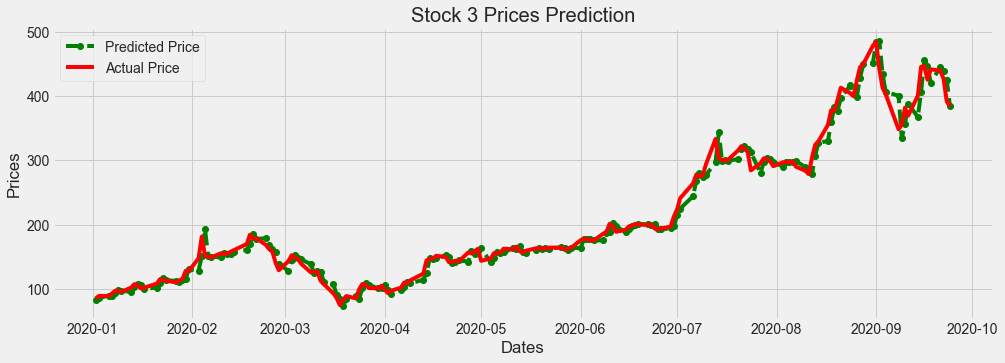

In [112]:
plt.figure(figsize=(15,5))
plt.plot(test_data_3.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data_3.index, test_data_3['VWAP'], color='red', label='Actual Price')
plt.title('Stock 3 Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.xticks(np.arange(1243,1427, 300), tesla.index()[1243:1427:300])
plt.legend()

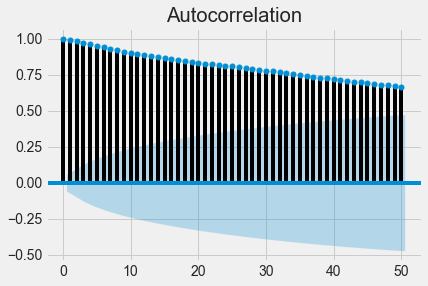

In [261]:
plt=sm.graphics.tsa.plot_acf(train_data['VWAP'], lags=50)

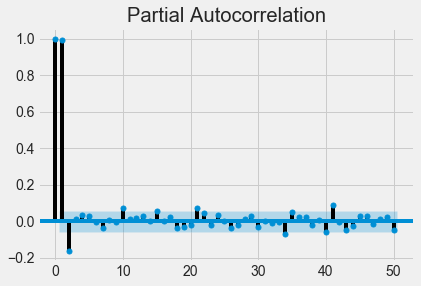

In [260]:
plt=sm.graphics.tsa.plot_pacf(train_data['VWAP'], lags=50)